# Analyses des résultats pour le mémoire

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from models import get_pretrained
from loggers import set_level, add_handler
from utils import set_display_options, load_json, plot, plot_multiple
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time
from models.model_utils import get_model_history, compare_models, get_models, remove_training_checkpoint

#set_level('time')
set_display_options(width = 150)

model_name = 'm5_nq_coqa_newsqa'

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.6.2


## Model analysis

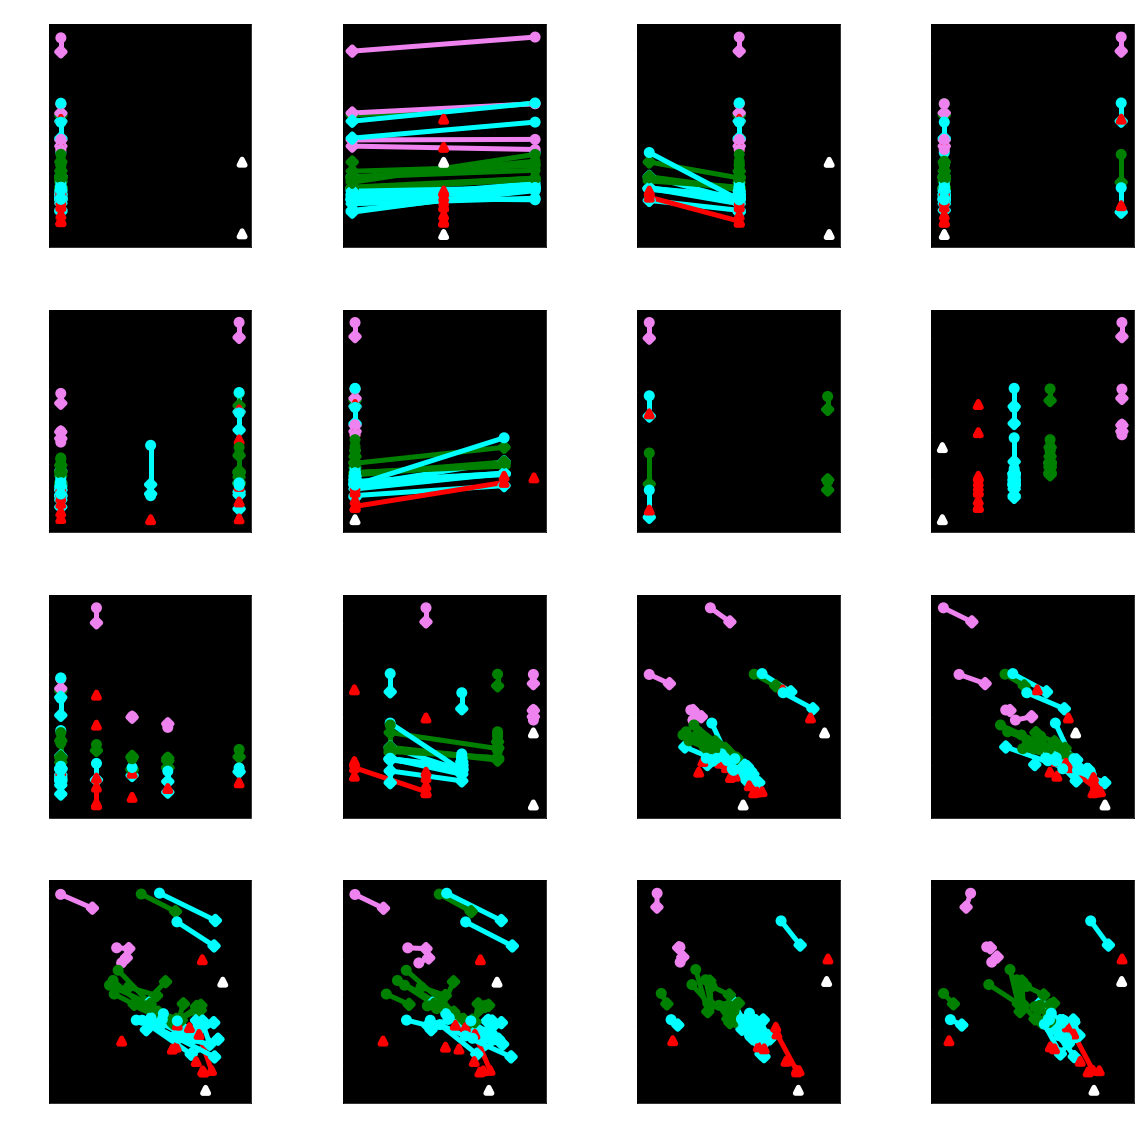

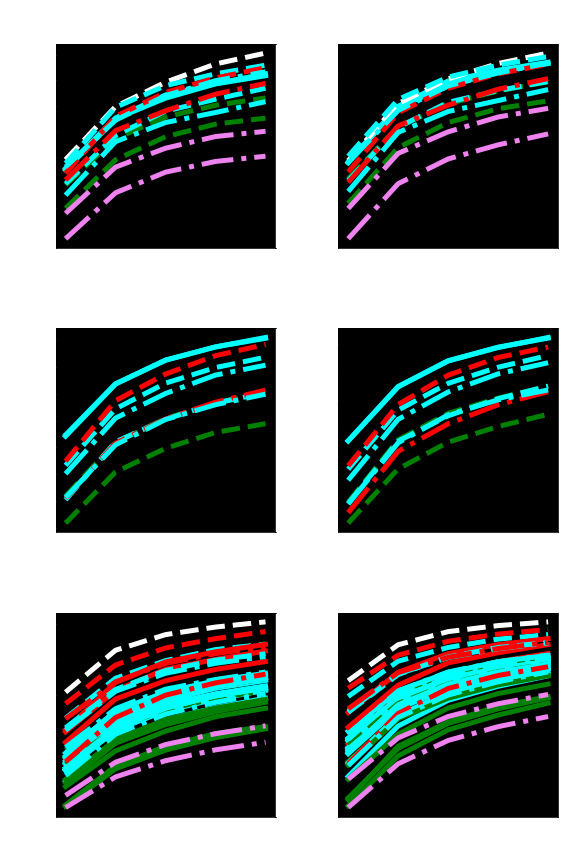

,class,encoder_subsampling_mode,negative_mode,split_contexts,context_offset,max_negatives,max_sent_per_ctx,encoder_subsampling_step,encoder_subsample_at,batch_size,pretrained_name,val_loss,val_EM,val_F1,test_EM,test_F1,test_squad_EM,test_squad_F1,nom
m3_nq,AnswerGenerator,none,none,False,NaN,-1,NaN,0,NaN,6,facebook/bart-large,0.428246,0.38391,0.755343,0.400495,0.571746,0.452199,0.664816,m3_nq
m4_nq_mag_off64_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,64,-1,NaN,1,4,3,facebook/bart-large,0.480003,0.396349,0.742796,0.398824,0.563868,0.448973,0.651776,m4_nq_mag_off64_entq_ct_wt_ib_1_4_mean
m4_nq_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,128,-1,NaN,1,4,3,facebook/bart-large,0.483355,0.400371,0.746873,0.397896,0.566845,0.453727,0.676579,m4_nq_mag_off_entq_ct_wt_ib_1_4_mean
m3_nq_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,-1,-1,NaN,1,4,3,facebook/bart-large,0.484609,0.40625,0.750669,0.405631,0.572778,0.448463,0.662265,m3_nq_mag_off_entq_ct_wt_ib_1_4_mean
m3_nq_mag_off_entq_ct_wt_ib_1_6_mean,MAG,none,batch,False,-1,-1,NaN,1,6,3,facebook/bart-large,0.509791,0.391089,0.745474,0.392327,0.558955,0.427916,0.63431,m3_nq_mag_off_entq_ct_wt_ib_1_6_mean
m4_nq_mag_split_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,True,128,-1,-1,2,2,2,m4_nq_mag_split_off_entq_ct_wt_ib_2_2_mean,0.522927,0.402369,0.755045,0.408248,0.591022,0.384716,0.621056,m4_nq_mag_split_off_entq_ct_wt_ib_2_2_dense
m3_nq_mag_off_entq_ct_wt_ib_2_8_dense,MAG,dense,batch,False,-1,-1,NaN,2,8,4,m3_nq_mag_off_entq_ct_wt_ib_2_8_mean,0.530615,0.388614,0.725462,0.387995,0.561208,0.378842,0.590269,m3_nq_mag_off_entq_ct_wt_ib_2_8_dense
m3_nq_mag_off_entq_ct_wt_ib_1_8_mean,MAG,none,batch,False,-1,-1,NaN,1,8,3,facebook/bart-large,0.54495,0.368812,0.743351,0.371597,0.545684,0.385125,0.577362,m3_nq_mag_off_entq_ct_wt_ib_1_8_mean
m4_nq_mag_split_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,True,128,-1,-1,1,4,1,facebook/bart-large,0.550447,0.374304,0.7054,0.374953,0.533933,0.373346,0.567983,m4_nq_mag_split_off_entq_ct_wt_ib_1_4_mean
m3_nq_mag_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,False,-1,-1,NaN,2,2,4,m3_nq_mag_off_entq_ct_wt_ib_2_2_mean,0.558676,0.395421,0.739937,0.404084,0.58374,0.379012,0.607756,m3_nq_mag_off_entq_ct_wt_ib_2_2_dense


In [3]:
def _extract_topk_tests(infos, color_corr):
    def _is_increasing(scores):
        for i in range(2, 6):
            if scores[str(i)] < scores[str(i-1)]: return False
        return True
    
    top5_prefix = sorted(set([c.split('-')[0] for c in infos.columns if 'top5' in c and 'test' in c]))
    to_drop     = [c for c in infos.columns if 'top5' in c]
    
    top5_results = {}
    for prefix in top5_prefix:
        top5_results[prefix] = {'x' : {}, 'with_legend' : False}
        for _, row in infos.iterrows():
            if row['nom'].startswith('m4_') and not ('squad' in prefix or 'ft_doc' in row['nom']): continue
            
            k = np.array(sorted([int(c.split('-')[-1]) for c in infos.columns if c.startswith(prefix)]))
            score = {c.split('-')[1] : row[c] for c in infos.columns if c.startswith(prefix)}
            if not _is_increasing(score): continue
            top5_results[prefix]['x'][row['nom']] = {
                'x' : k,
                'y' : np.array([score[str(k)] for k in k]),
                'c' : _colors[row[color_corr]],
                'ls': _styles[row['nom'][:2]] if 'split' not in row['nom'] else '-.'
            }
    return infos.drop(to_drop, axis = 1), top5_results

def plot_and_sort(infos, metric = 'val_loss', color_corr = 'encoder_subsampling_step',
                  separate_top_k = True, shape_corr = None, ascending = True):
    to_drop = [c for c in _cols_to_drop if c in infos.columns]
    to_drop += [c for c in infos.columns if any([m in c for m in _metrics_to_drop])]
    to_drop += [c for c in infos.columns if 'test_doc' in c and '-' not in c]
    infos = infos.drop(to_drop, axis = 1)
    if 'negative_mode' in infos.columns:
        infos['negative_mode'].fillna('none', inplace = True)
        infos.loc[infos['negative_mode'] != 'doc', 'max_negatives'] = -1
        
    if 'split_contexts' in infos.columns:
        infos['split_contexts'].fillna(False, inplace = True)
        infos.loc[infos['split_contexts'] != False, 'max_sent_per_ctx'] = -1

    if 'encoder_subsampling_mode' in infos.columns:
        infos['encoder_subsampling_mode'].fillna('none', inplace = True)
        if 'encoder_subsampling_step' in infos.columns:
            infos['encoder_subsampling_step'].fillna(0, inplace = True)
            infos.loc[infos['encoder_subsampling_step'] < 2, 'encoder_subsampling_mode'] = 'none'

    infos['nom'] = infos.index
    infos, top_k_tests = _extract_topk_tests(infos, color_corr)
    
    if not separate_top_k:
        plot_multiple(
            infos, corr = metric, ** top_k_tests, linewidth = 5,
            color_corr = color_corr if color_corr in infos.columns else None, color_order = _colors,
            shape_corr = shape_corr if shape_corr in infos.columns else None, shape_order = _shapes,
            link_from_to = ('pretrained_name', 'nom'),
            ncols = 4, x_size = 4, y_size = 4, show = True,
            filename = 'memoire_results/plots/metrics/{}.png'.format(metric)
        )
    else:

        plot_multiple(
            infos, corr = metric, linewidth = 5, xlabel = 'Param value',
            color_corr = color_corr if color_corr in infos.columns else None, color_order = _colors,
            shape_corr = shape_corr if shape_corr in infos.columns else None, shape_order = _shapes,
            link_from_to = ('pretrained_name', 'nom'),
            ncols = 4, x_size = 4, y_size = 4, show = True,
            filename = 'memoire_results/plots/metrics/{}.png'.format(metric)
        )
            
        plot_multiple(
            ** {'\n' + k : v for k, v in top_k_tests.items()}, linewidth = 5, use_subplots = True,
            title = 'Top-K prediction metrics', xlabel = 'k', ylabel = 'metric value',
            ncols = 2, x_size = 4, y_size = 4, show = True,
            filename = 'memoire_results/plots/metrics/top-k.png'
        )


    return infos.sort_values(metric, ascending = ascending)

_colors = {
    i : color for i, color in enumerate(['w', 'r', 'cyan', 'g', 'b', 'violet'])
}
_shapes = {
    mode : shape for mode, shape in [('none', '^'), ('mean', 'o'), ('dense', 'D')]
}
_styles = {
    'm3' : 'dotted',
    'm4' : 'solid',
    'm5' : '--'
}
_cols_to_drop = [
    'input_format', 'shuffle_size', 'eval_infer_config', 'augment_prct', 'max_output_length',
    'encoder_max_types', 'encoder_subsample_after', 'epochs', 'loss', 'EM', 'F1',
    'encoder_use_type_embedding'
]
_metrics_to_drop = ['accuracy', 'precision', 'recall']

names = get_models('m3_nq_mag_off_entq_ct_wt_*') + ['m3_nq']
names += get_models('m5_*') + get_models('m4_*')

# names += [n for n in os.listdir('pretrained_models') if n.startswith('test_mag_')]

infos = compare_models(names, True, True, epoch = 'last', add_training_config = True)

plot_and_sort(
    infos, 'val_loss',
    color_corr = 'encoder_subsampling_step' if 'encoder_subsampling_step' in infos.columns else 'negative_mode',
    shape_corr = 'encoder_subsampling_mode'
)

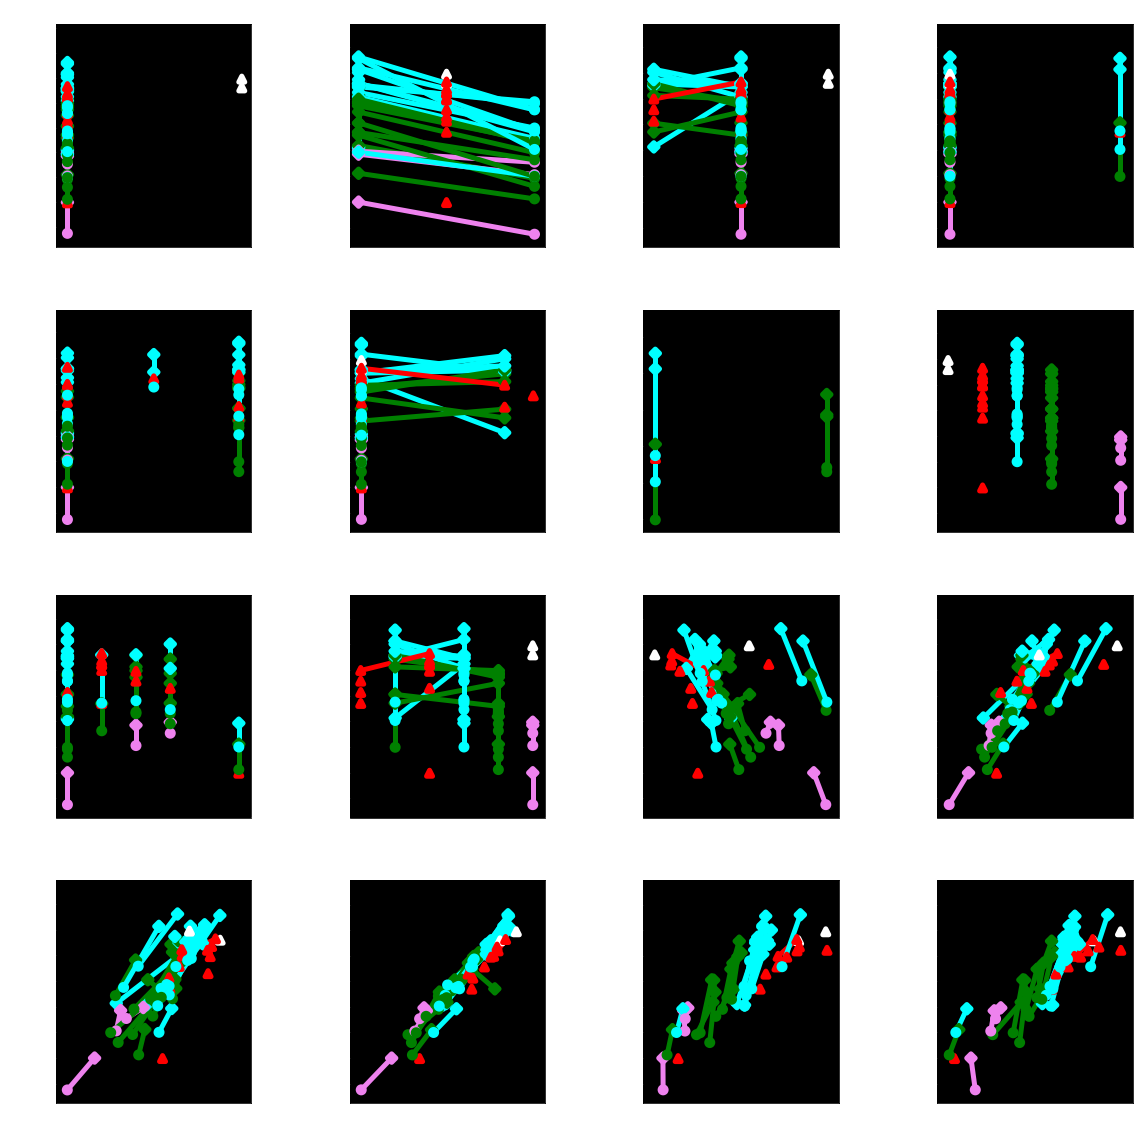

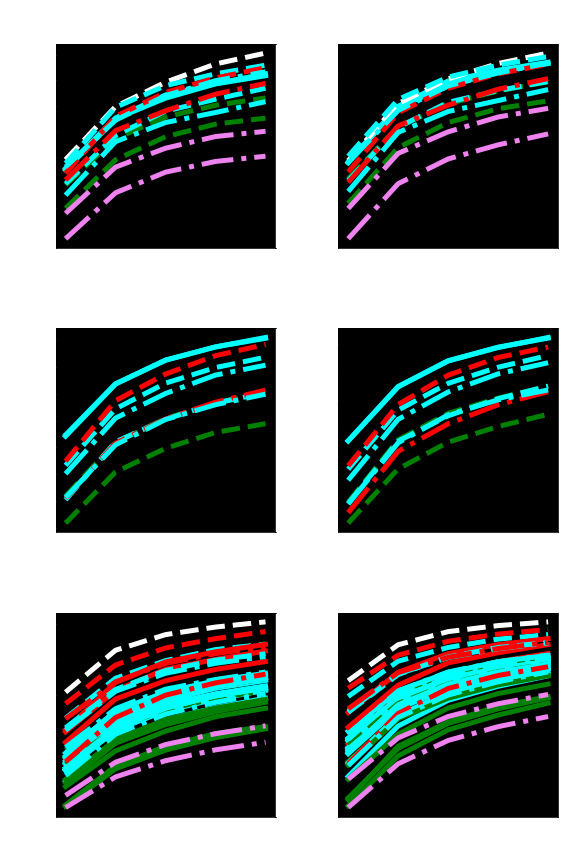

,class,encoder_subsampling_mode,negative_mode,split_contexts,context_offset,max_negatives,max_sent_per_ctx,encoder_subsampling_step,encoder_subsample_at,batch_size,pretrained_name,val_loss,val_EM,val_F1,test_EM,test_F1,test_squad_EM,test_squad_F1,nom
m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,False,128,-1,NaN,2,2,4,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_mean,0.83702,0.466337,0.713112,0.407797,0.592135,0.455765,0.696827,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense
m4_nq_mag_split_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,True,128,-1,-1,2,2,2,m4_nq_mag_split_off_entq_ct_wt_ib_2_2_mean,0.522927,0.402369,0.755045,0.408248,0.591022,0.384716,0.621056,m4_nq_mag_split_off_entq_ct_wt_ib_2_2_dense
m3_nq_mag_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,False,-1,-1,NaN,2,2,4,m3_nq_mag_off_entq_ct_wt_ib_2_2_mean,0.558676,0.395421,0.739937,0.404084,0.58374,0.379012,0.607756,m3_nq_mag_off_entq_ct_wt_ib_2_2_dense
m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense,MAG,dense,doc,False,64,4,NaN,2,2,2,m4_nq_mag_off64_entq_ct_wt_ib_2_2_dense,0.6198,0.375,0.725918,0.407488,0.582603,0.378842,0.620146,m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense
m5_nq_coqa_newsqa_mag_split_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,True,128,-1,-1,2,2,2,m5_nq_coqa_newsqa_mag_split_off_entq_ct_wt_ib_...,0.908982,0.440199,0.694611,0.408936,0.582516,NaN,NaN,m5_nq_coqa_newsqa_mag_split_off_entq_ct_wt_ib_...
m3_nq_mag_off_entq_ct_wt_ft_doc_2_8_dense,MAG,dense,doc,False,-1,4,NaN,2,8,2,m3_nq_mag_off_entq_ct_wt_ib_2_8_dense,0.572929,0.392636,0.738812,0.4112,0.580169,0.396332,0.615451,m3_nq_mag_off_entq_ct_wt_ft_doc_2_8_dense
m5_nq_coqa_newsqa,AnswerGenerator,none,none,False,NaN,-1,NaN,0,NaN,6,facebook/bart-large,0.734515,0.480133,0.724917,0.415351,0.578825,0.507896,0.726306,m5_nq_coqa_newsqa
m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense,MAG,dense,doc,False,128,4,NaN,2,2,2,m4_nq_mag_off_entq_ct_wt_ib_2_2_dense,0.624328,0.362933,0.710404,0.397896,0.574636,0.368314,0.595736,m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense
m3_nq_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,-1,-1,NaN,1,4,3,facebook/bart-large,0.484609,0.40625,0.750669,0.405631,0.572778,0.448463,0.662265,m3_nq_mag_off_entq_ct_wt_ib_1_4_mean
m3_nq_mag_off_entq_ct_wt_ib_2_6_dense,MAG,dense,batch,False,-1,-1,NaN,2,6,4,m3_nq_mag_off_entq_ct_wt_ib_2_6_mean,0.597187,0.385829,0.725776,0.393874,0.571795,0.364408,0.601142,m3_nq_mag_off_entq_ct_wt_ib_2_6_dense


In [4]:
plot_and_sort(
    infos, 'test_F1',
    color_corr = 'encoder_subsampling_step' if 'encoder_subsampling_step' in infos.columns else 'negative_mode',
    shape_corr = 'encoder_subsampling_mode',
    ascending  = False
)

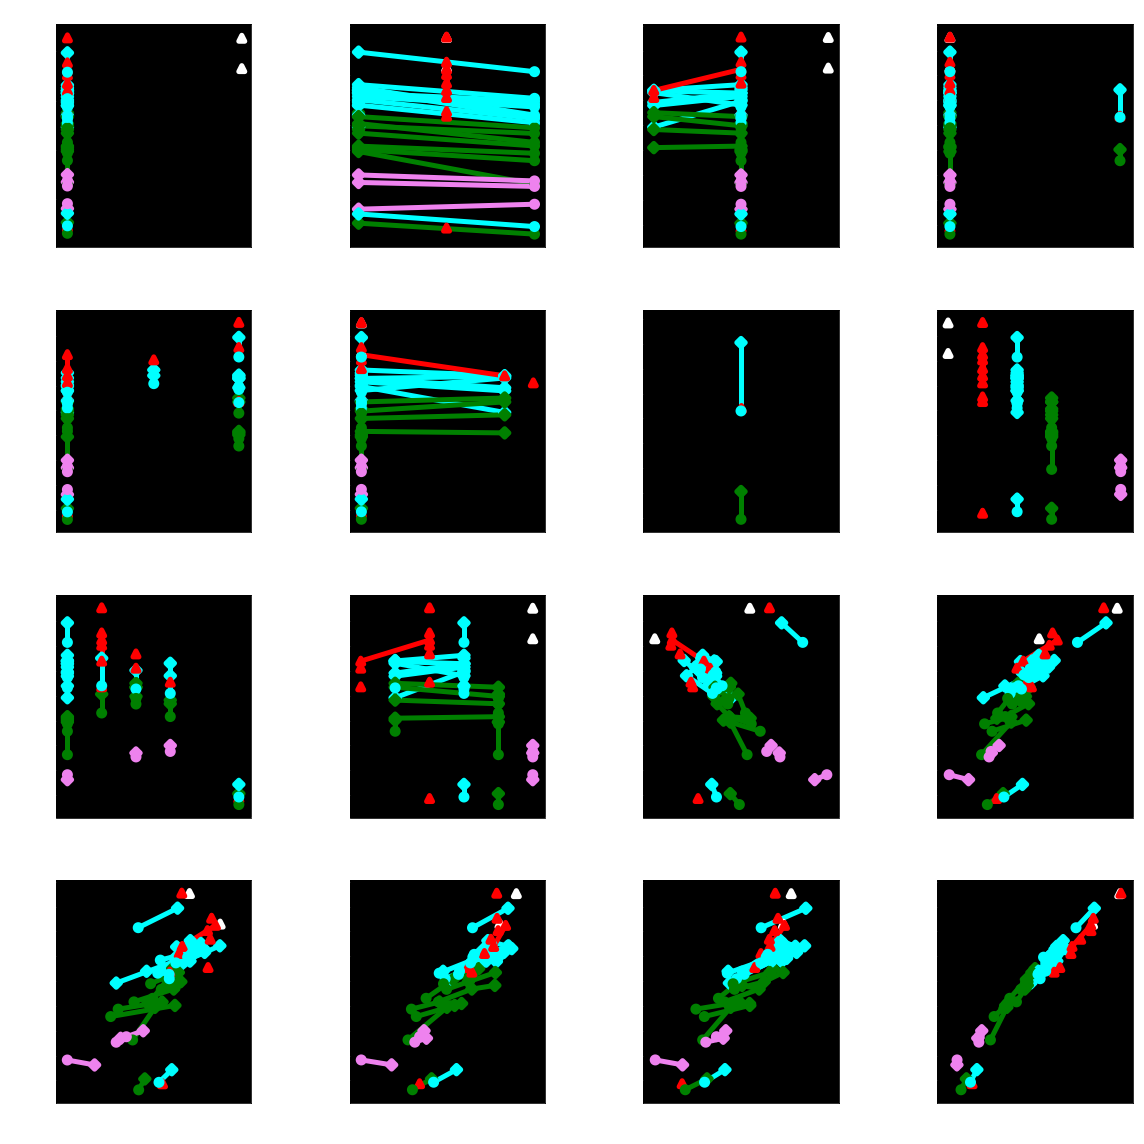

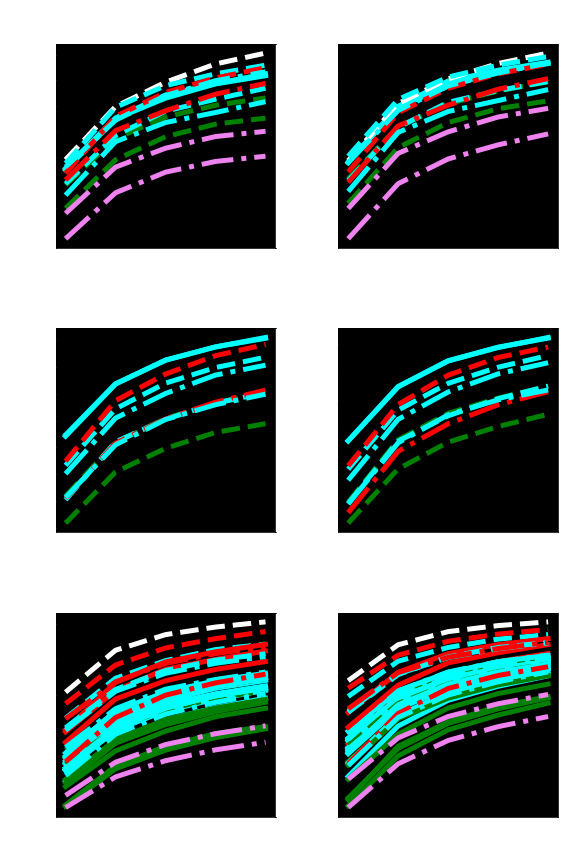

,class,encoder_subsampling_mode,negative_mode,split_contexts,context_offset,max_negatives,max_sent_per_ctx,encoder_subsampling_step,encoder_subsample_at,batch_size,pretrained_name,val_loss,val_EM,val_F1,test_EM,test_F1,test_squad_EM,test_squad_F1,nom
m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,128,-1,NaN,1,4,3,facebook/bart-large,0.797951,0.463457,0.717314,0.397587,0.564331,0.510443,0.727127,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean
m5_nq_coqa_newsqa,AnswerGenerator,none,none,False,NaN,-1,NaN,0,NaN,6,facebook/bart-large,0.734515,0.480133,0.724917,0.415351,0.578825,0.507896,0.726306,m5_nq_coqa_newsqa
m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,False,128,-1,NaN,2,2,4,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_mean,0.83702,0.466337,0.713112,0.407797,0.592135,0.455765,0.696827,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense
m4_nq_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,128,-1,NaN,1,4,3,facebook/bart-large,0.483355,0.400371,0.746873,0.397896,0.566845,0.453727,0.676579,m4_nq_mag_off_entq_ct_wt_ib_1_4_mean
m3_nq,AnswerGenerator,none,none,False,NaN,-1,NaN,0,NaN,6,facebook/bart-large,0.428246,0.38391,0.755343,0.400495,0.571746,0.452199,0.664816,m3_nq
m3_nq_mag_off_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,-1,-1,NaN,1,4,3,facebook/bart-large,0.484609,0.40625,0.750669,0.405631,0.572778,0.448463,0.662265,m3_nq_mag_off_entq_ct_wt_ib_1_4_mean
m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_mean,MAG,mean,batch,False,128,-1,NaN,2,2,4,facebook/bart-large,0.905064,0.431111,0.674139,0.375619,0.551501,0.418237,0.657527,m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_mean
m4_nq_mag_off64_entq_ct_wt_ib_1_4_mean,MAG,none,batch,False,64,-1,NaN,1,4,3,facebook/bart-large,0.480003,0.396349,0.742796,0.398824,0.563868,0.448973,0.651776,m4_nq_mag_off64_entq_ct_wt_ib_1_4_mean
m3_nq_mag_off_entq_ct_wt_ib_1_6_mean,MAG,none,batch,False,-1,-1,NaN,1,6,3,facebook/bart-large,0.509791,0.391089,0.745474,0.392327,0.558955,0.427916,0.63431,m3_nq_mag_off_entq_ct_wt_ib_1_6_mean
m4_nq_mag_off64_entq_ct_wt_ib_2_2_dense,MAG,dense,batch,False,64,-1,NaN,2,2,4,m4_nq_mag_off64_entq_ct_wt_ib_2_2_mean,0.582562,0.383354,0.725748,0.389542,0.569046,0.391917,0.631508,m4_nq_mag_off64_entq_ct_wt_ib_2_2_dense


In [5]:
plot_and_sort(
    infos, 'test_squad_F1',
    color_corr = 'encoder_subsampling_step' if 'encoder_subsampling_step' in infos.columns else 'negative_mode',
    shape_corr = 'encoder_subsampling_mode',
    ascending  = False
)

## Predictions' analysis

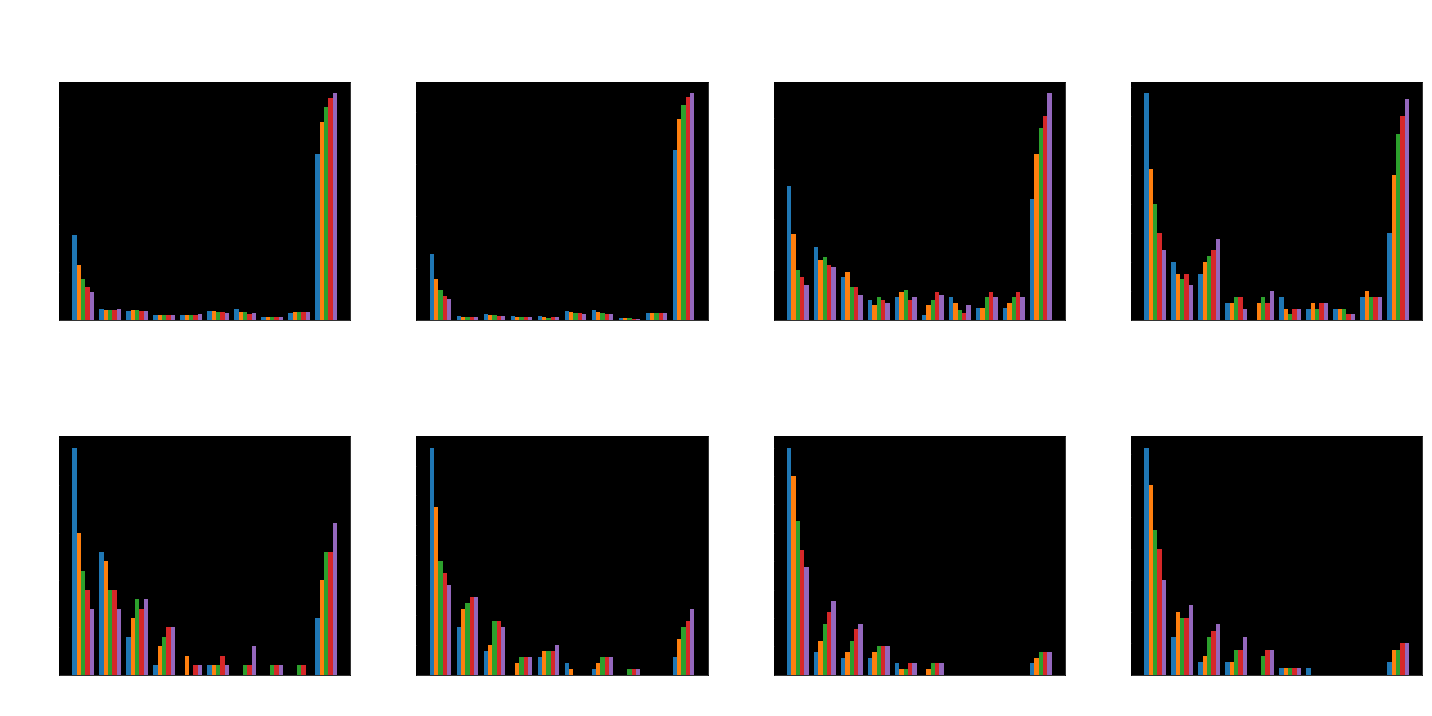

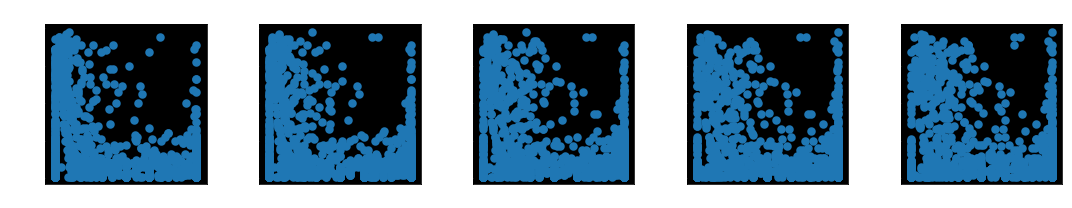

3233
[0.62257861 0.72191709 0.76950273 0.79415591 0.80934179]
3233
[0.6983560586064141, 0.7944759449795087, 0.8366447518272294, 0.8544322137968333, 0.8658605166311939]


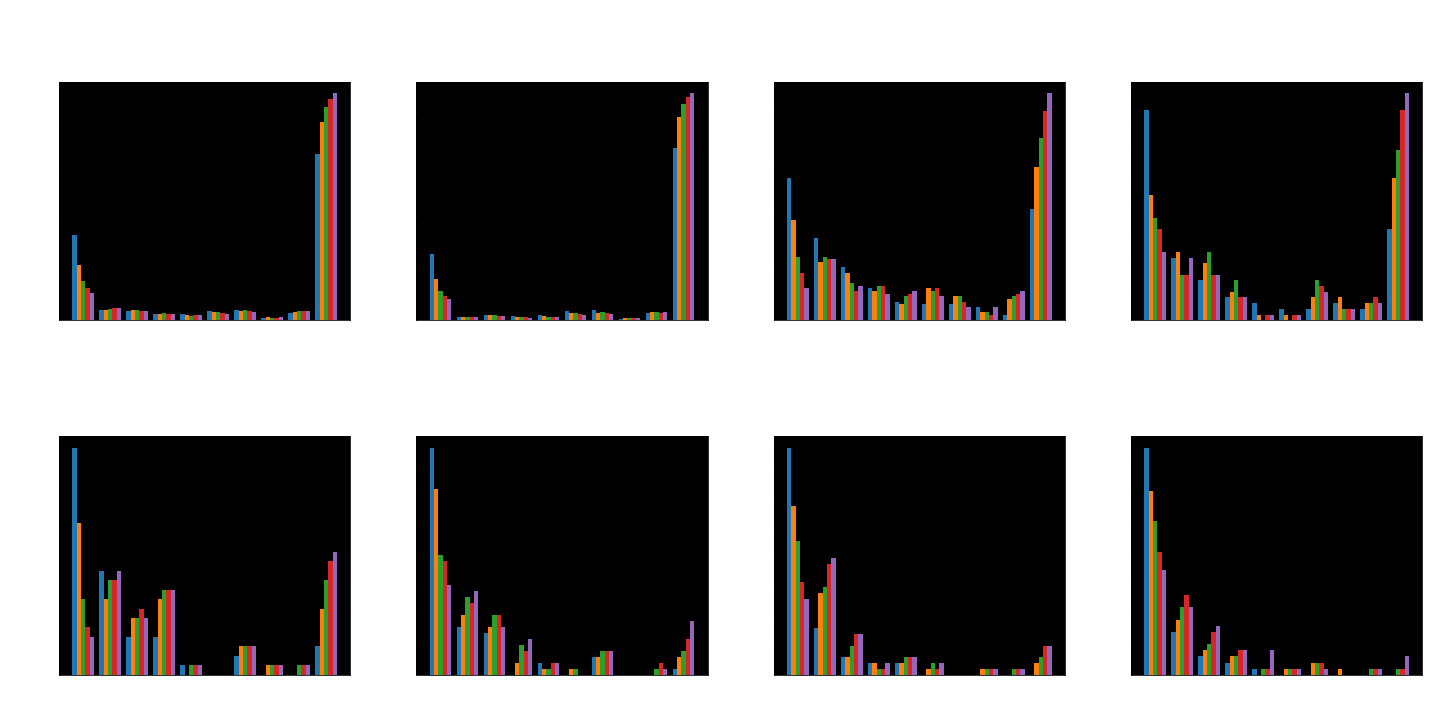

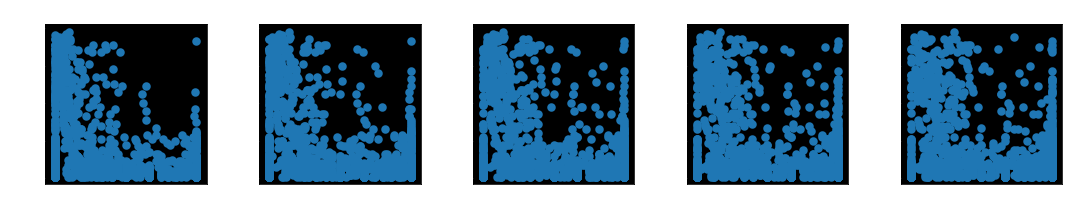

3233
[0.62130397 0.72060757 0.76910356 0.79225728 0.80913271]
3233
[0.7048587186847941, 0.7987939953214054, 0.8310295454385735, 0.8511464203469642, 0.865792470324198]


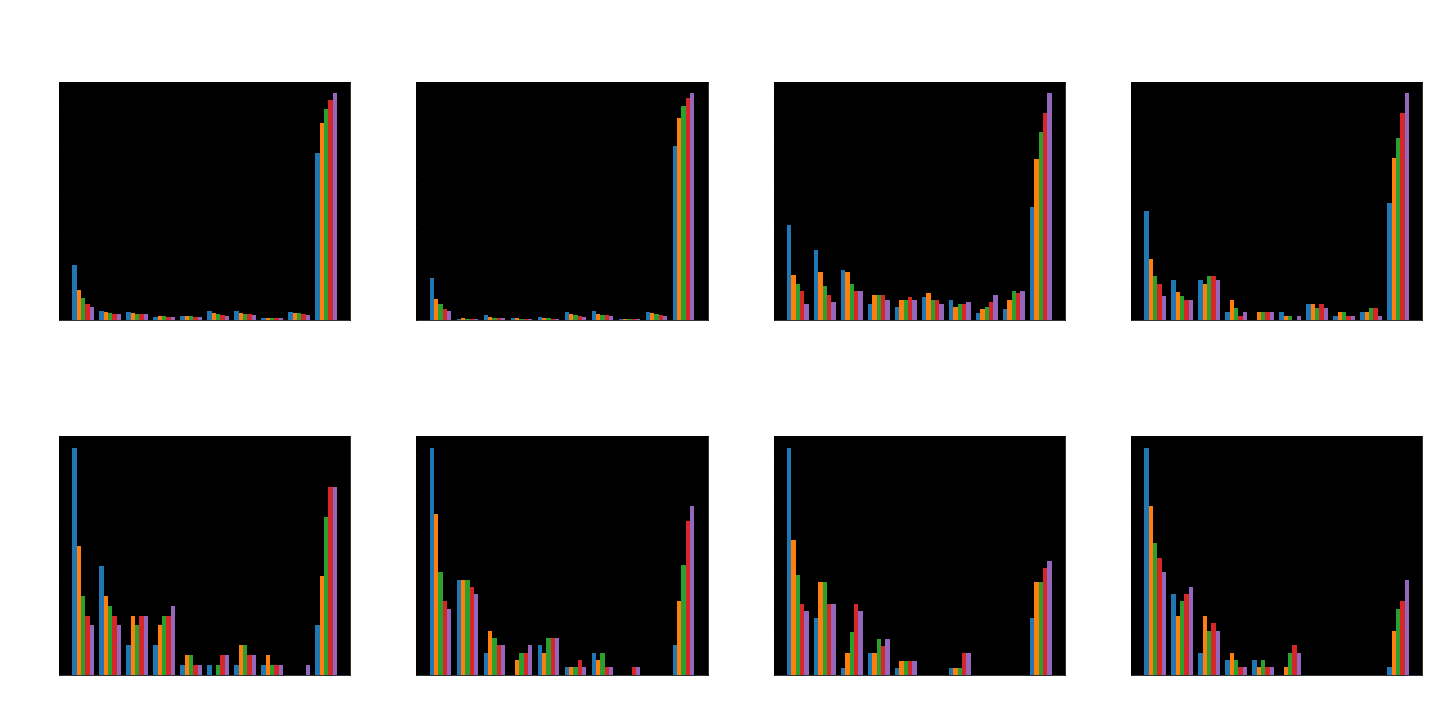

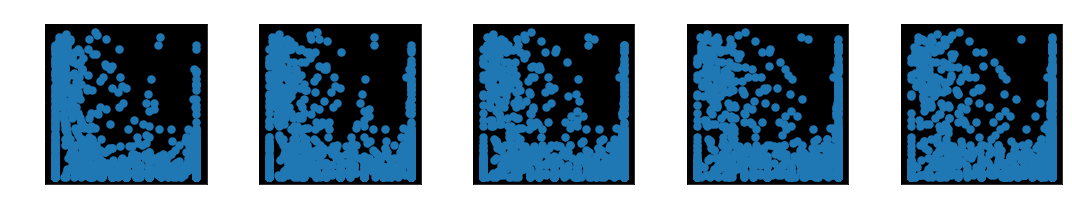

3232
[0.69986199 0.79738609 0.83944706 0.86564625 0.88340094]
3232
[0.7058822032396156, 0.8016351260023542, 0.8435054082829173, 0.8700335497718932, 0.8853556165600768]


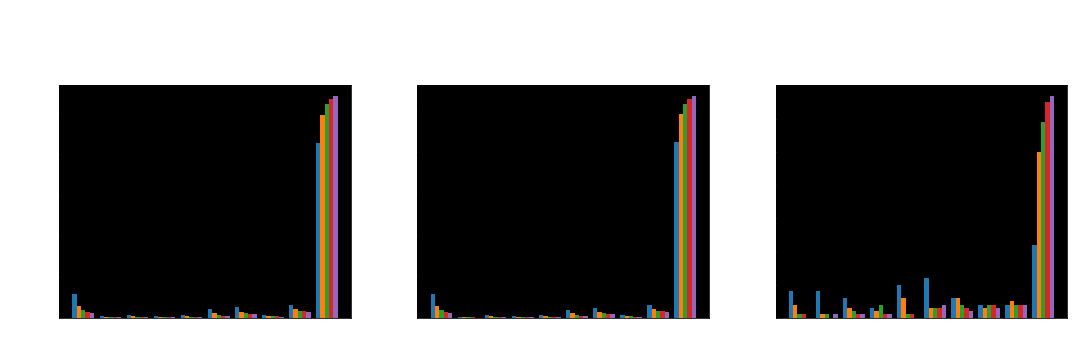

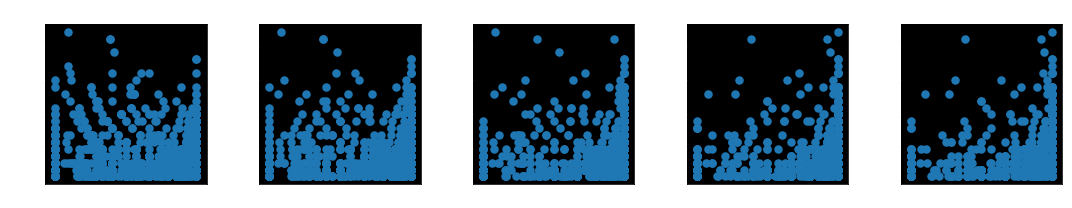

5887
[0.83161559 0.90940063 0.9378609  0.95095361 0.95895245]
3232
[0.7058822032396156, 0.8016351260023542, 0.8435054082829173, 0.8700335497718932, 0.8853556165600768]


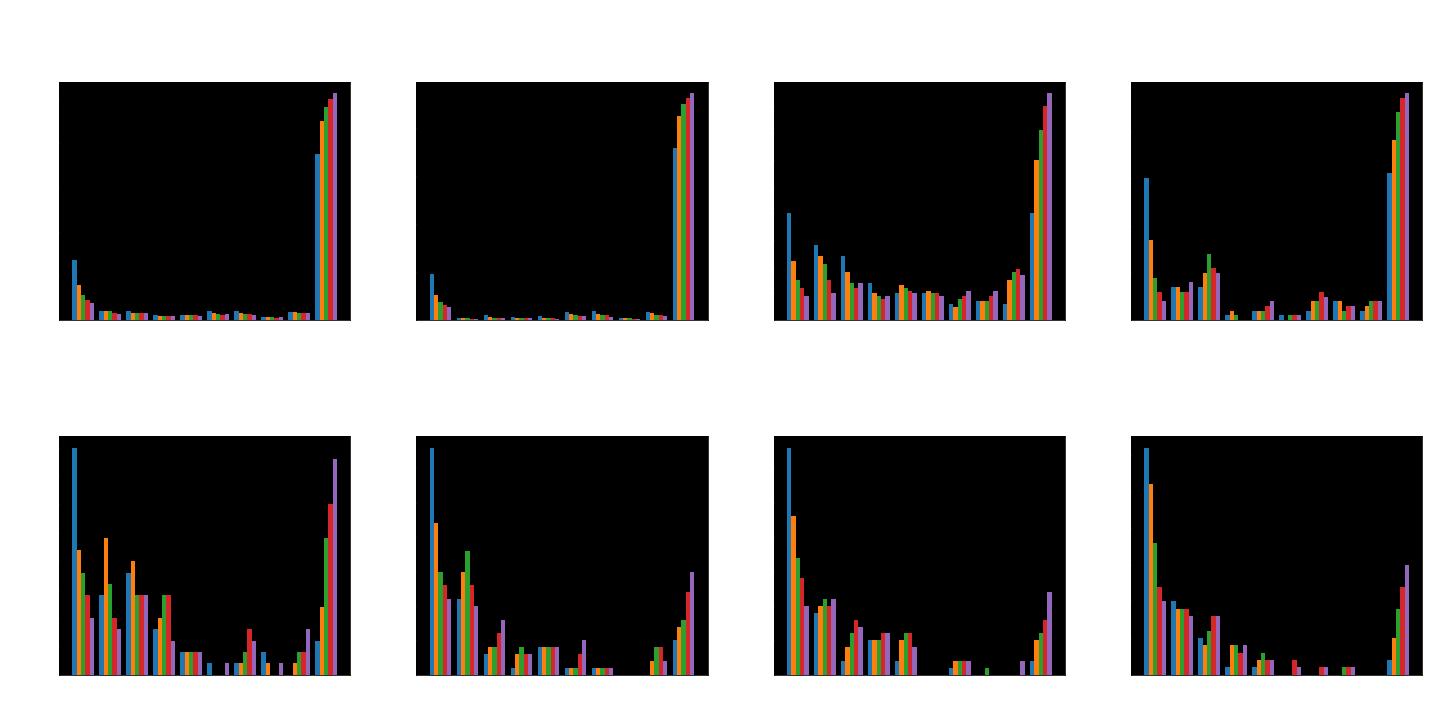

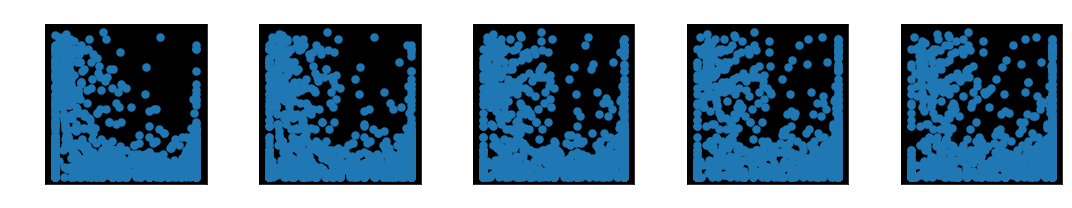

3233
[0.68081053 0.78185962 0.8234034  0.84816137 0.86446725]
539
[0.6787261205391892, 0.7805716417494865, 0.8187347656057142, 0.8495144346428272, 0.8666027961281545]


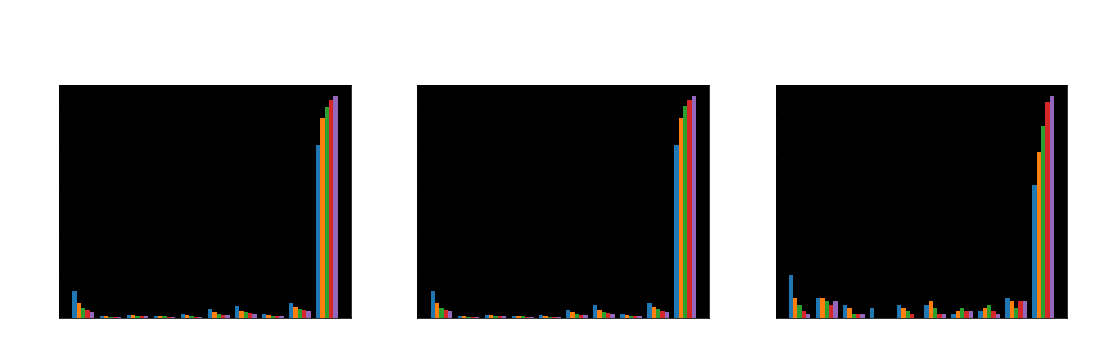

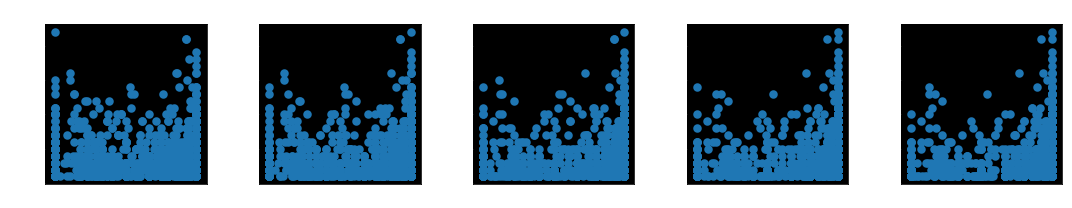

5887
[0.81551185 0.88681207 0.91692694 0.93251909 0.94262811]
539
[0.6787261205391892, 0.7805716417494865, 0.8187347656057142, 0.8495144346428272, 0.8666027961281545]


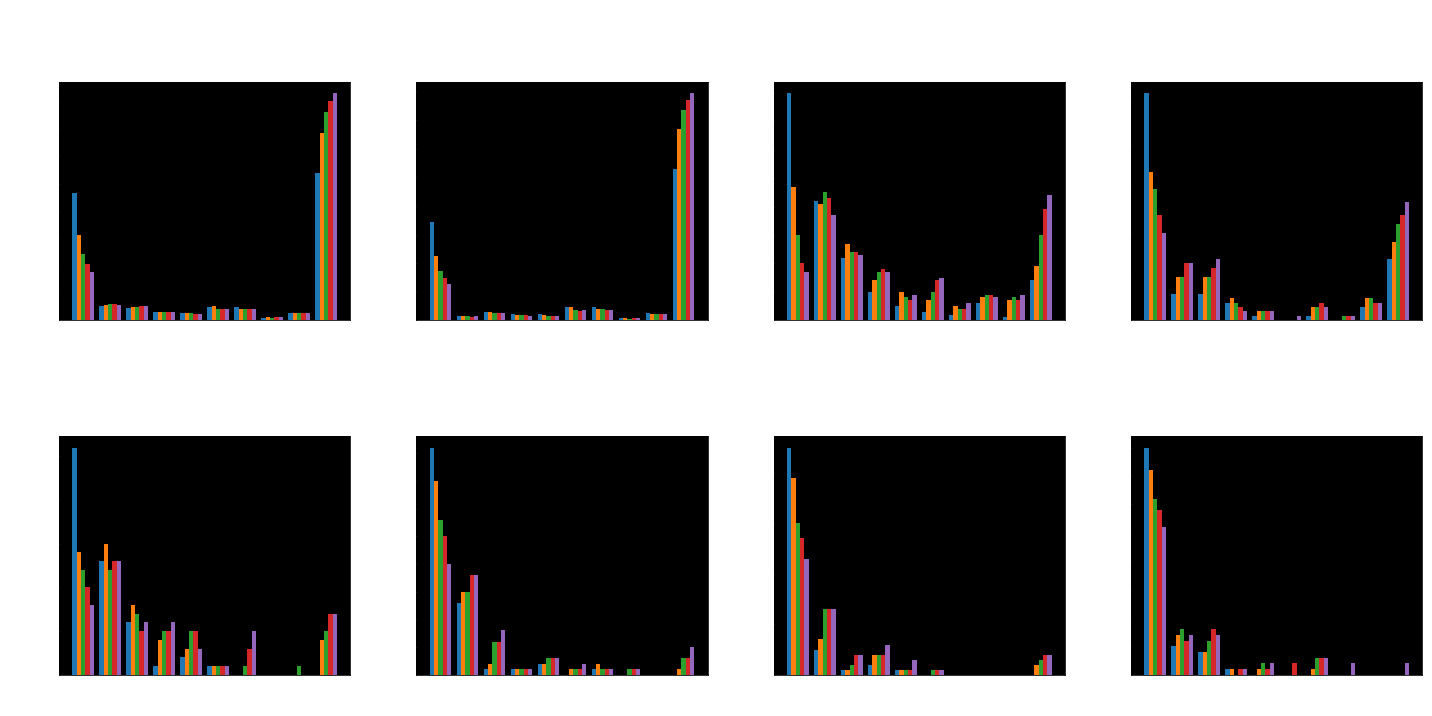

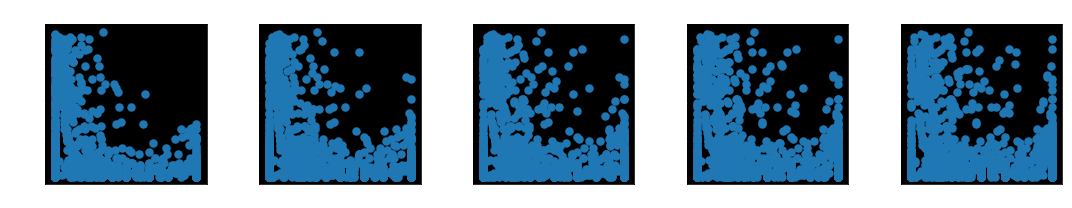

3233
[0.51695451 0.63080189 0.68631663 0.71502906 0.73905397]
539
[0.6787261205391892, 0.7805716417494865, 0.8187347656057142, 0.8495144346428272, 0.8666027961281545]


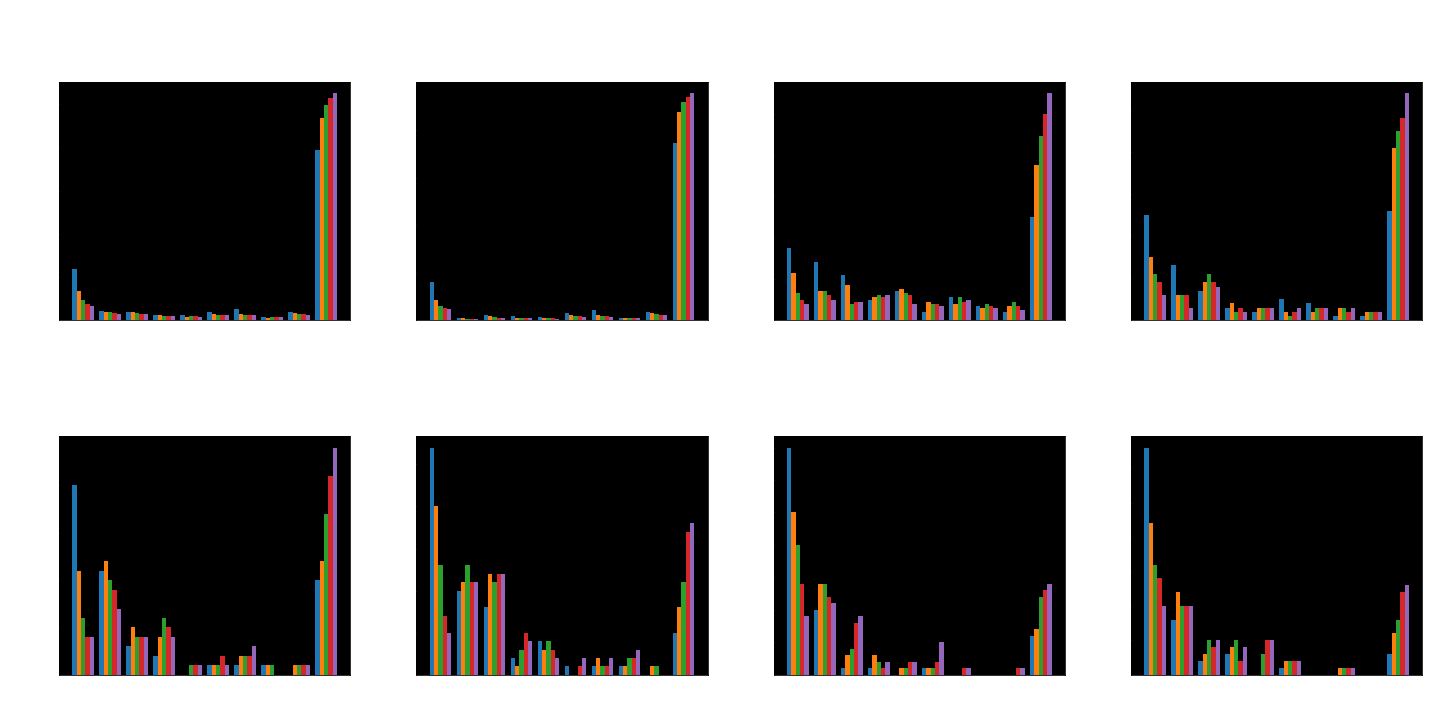

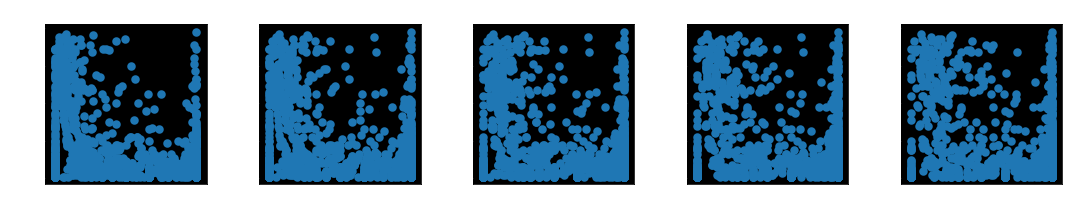

3233
[0.70869552 0.80408724 0.84294732 0.8620529  0.8771014 ]
539
[0.7105608928623801, 0.8086252916942943, 0.8475993201551278, 0.8672516106011031, 0.8800830051496431]


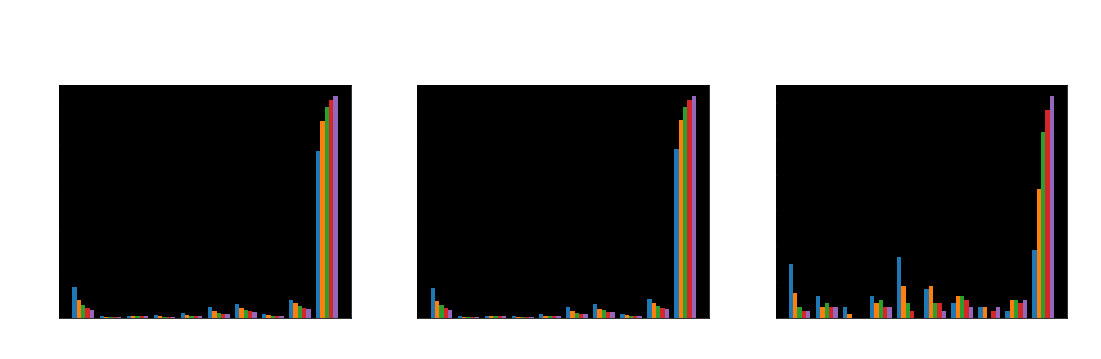

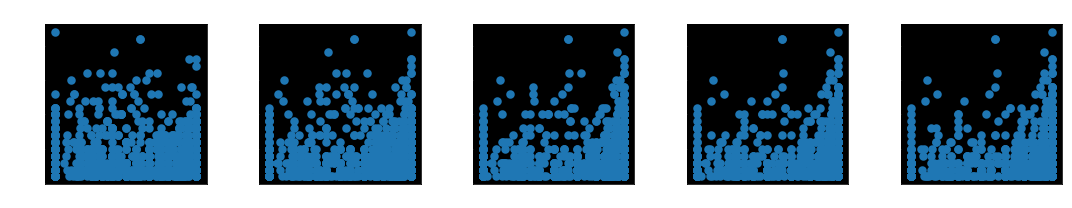

5887
[0.7955088  0.87351708 0.90355559 0.92189064 0.93167679]
539
[0.7105608928623801, 0.8086252916942943, 0.8475993201551278, 0.8672516106011031, 0.8800830051496431]


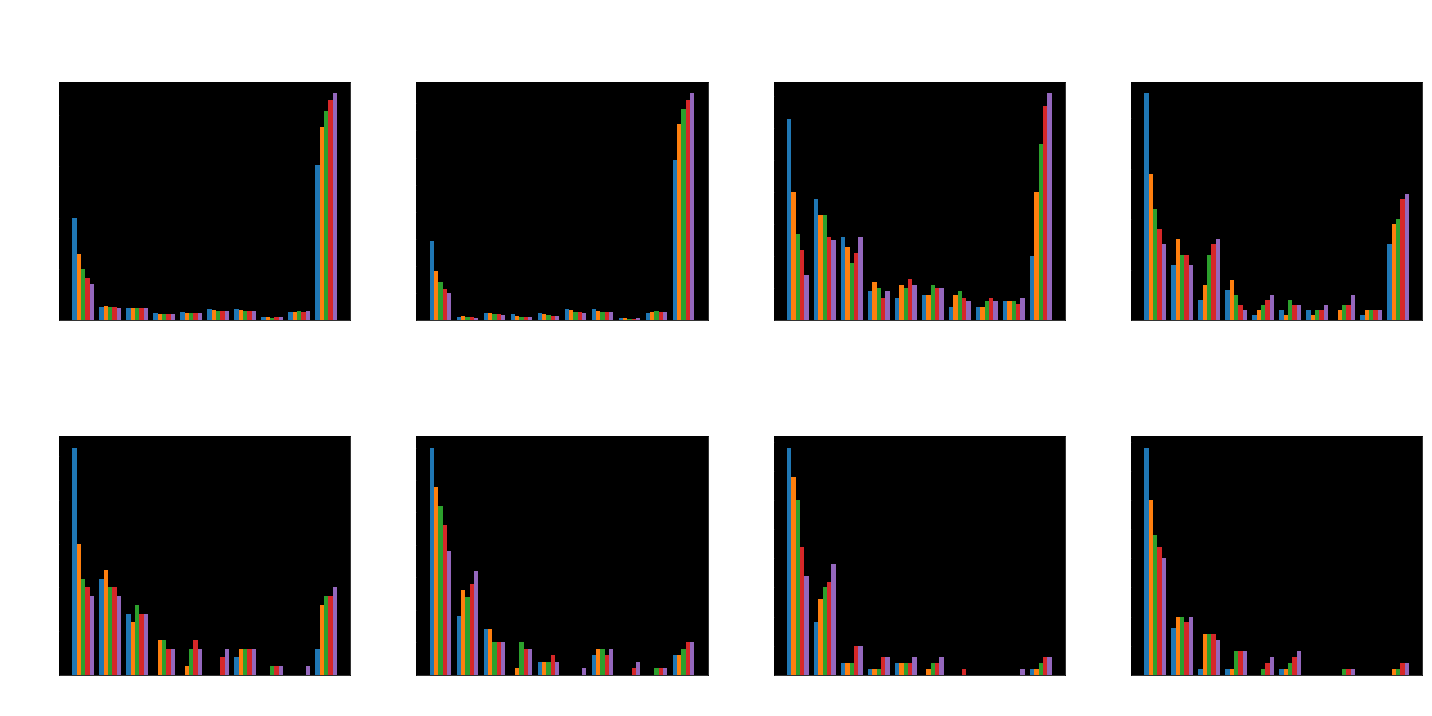

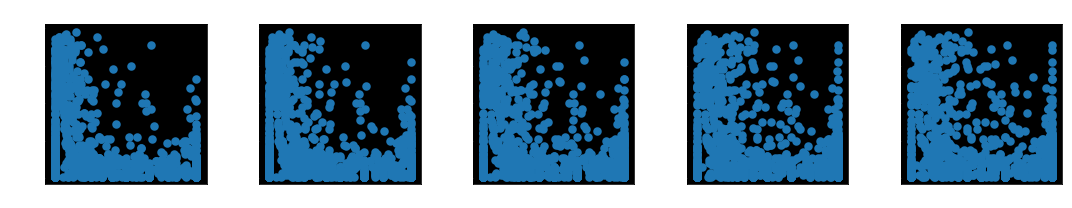

3233
[0.56988358 0.67914733 0.72645583 0.75699185 0.77863642]
539
[0.7105608928623801, 0.8086252916942943, 0.8475993201551278, 0.8672516106011031, 0.8800830051496431]


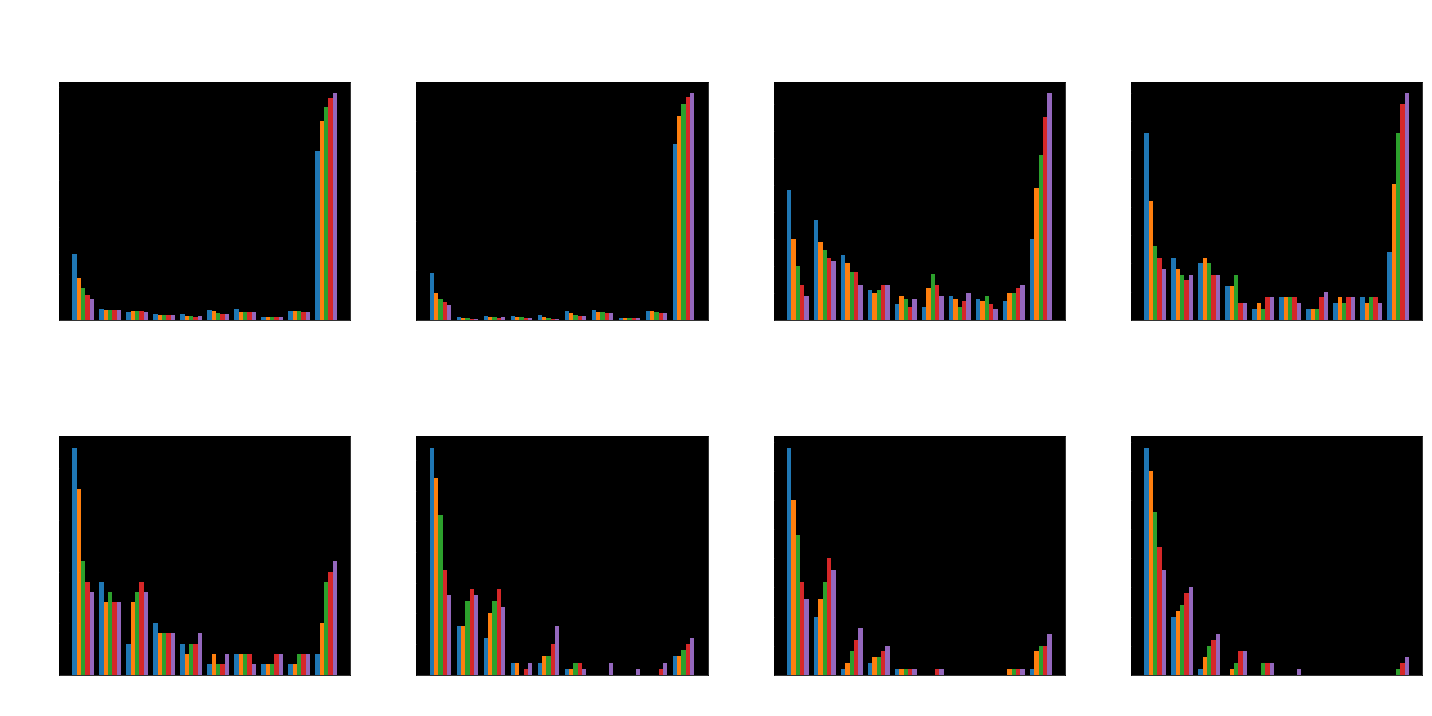

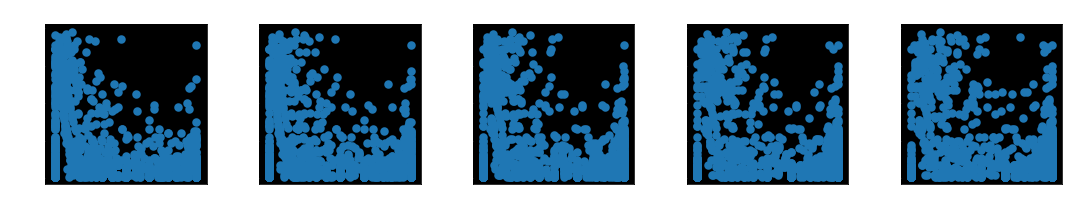

3233
[0.66671401 0.7559918  0.79503688 0.81930342 0.8355059 ]
539
[0.6759407687275661, 0.7686018051375706, 0.8067669546670507, 0.8287320866876718, 0.8440117304090666]


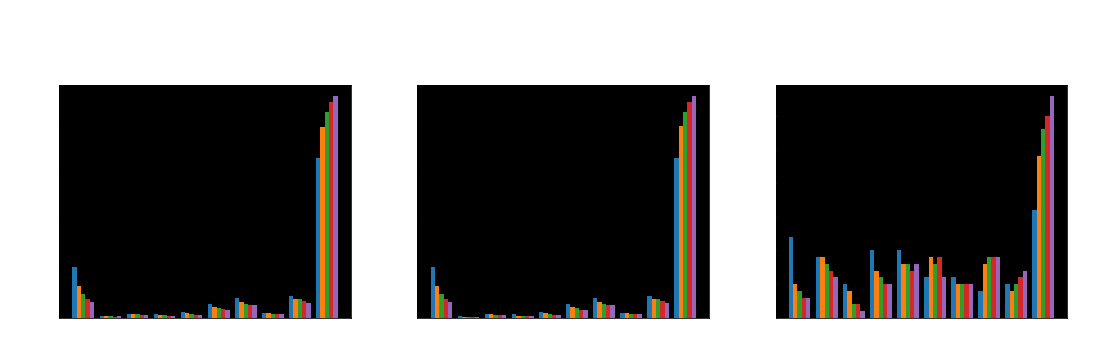

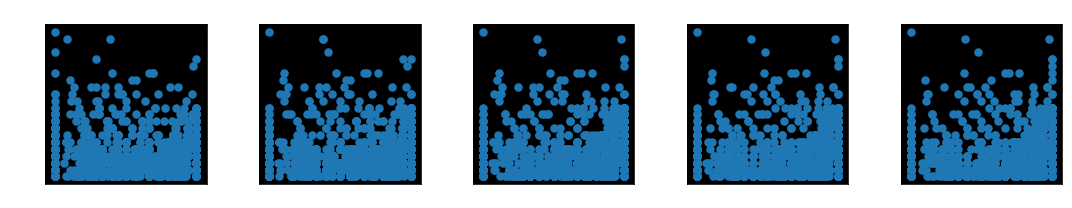

5887
[0.71888404 0.80507089 0.84165764 0.86584415 0.88034346]
539
[0.6759407687275661, 0.7686018051375706, 0.8067669546670507, 0.8287320866876718, 0.8440117304090666]


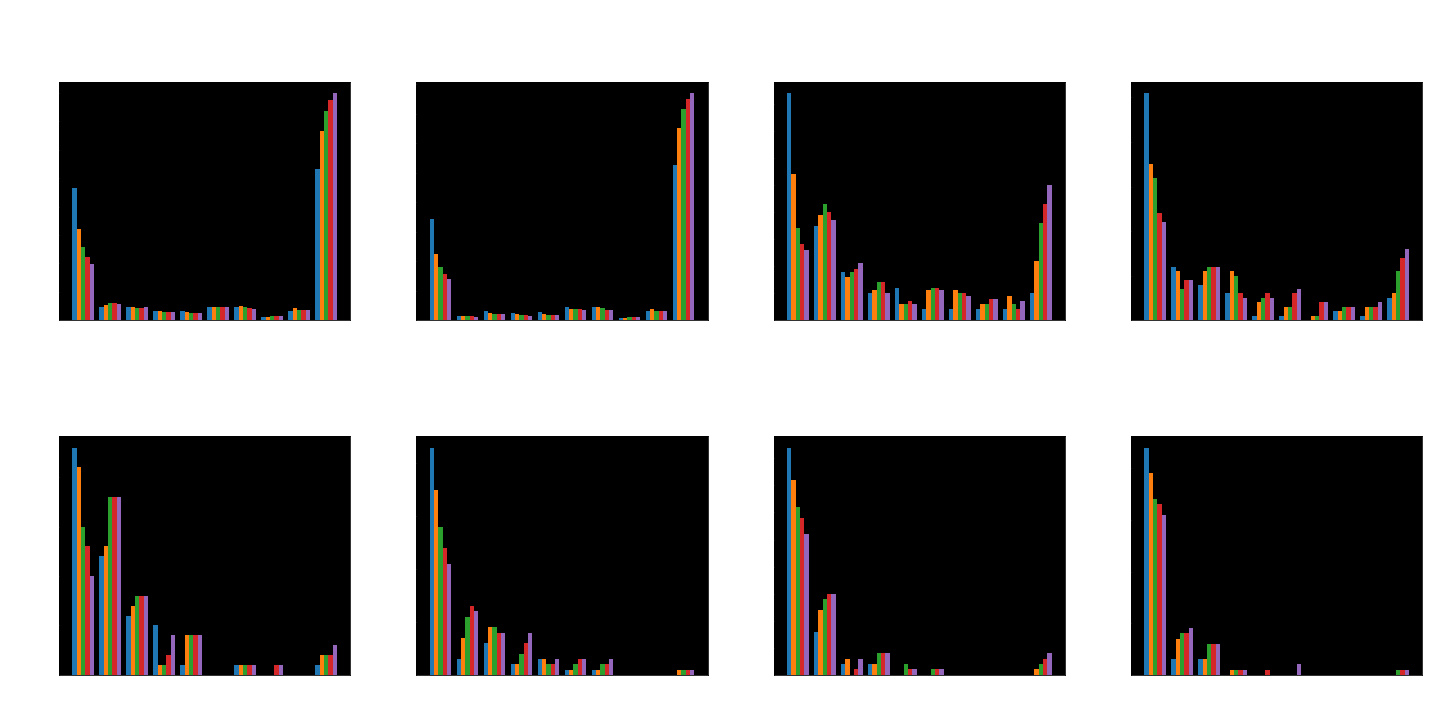

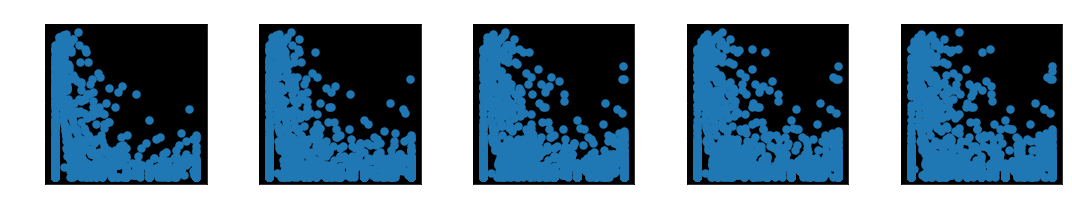

3233
[0.51621131 0.62508481 0.67585998 0.70236949 0.7217907 ]
539
[0.6759407687275661, 0.7686018051375706, 0.8067669546670507, 0.8287320866876718, 0.8440117304090666]


In [10]:
def analyse_pred(name, pred_name = 'pred'):
    path = os.path.join('mag_predictions', name, pred_name + '.json')
    
    data = load_json(path)
    if len(data) == 0: return

    f1, infos = [], []
    for q, preds in data.items():
        for ctx, p in preds.items():
            f1_i = [cand['F1'] for cand in p['candidates'] if 'F1' in cand]
            cum_f1 = [max(f1_i[:i+1]) for i in range(len(f1_i))]
            if len(f1_i) > 0:
                f1.append(cum_f1)
                infos.append({
                    'answer_length' : min([len(a.split()) for a in p['target']]),
                    ** {'f1-{}'.format(i) : cum_f1[i-1] for i in range(1, 6)}
                })

    len_to_f1 = {}
    f1 = np.array(f1)
    for i, info in enumerate(infos):
        len_to_f1.setdefault(info['answer_length'] // 10, []).append(f1[i])
    f1_plot = {
        '\nDistribution of F1' : f1, ** {
            '\nDistribution of F1 for\n{} <= |A| < {} (nb : {})\nTop-K F1 : [{}]'.format(
                i * 10, (i+1) * 10, len(len_to_f1[i]), ', '.join(['{:.1f}'.format(f1_k * 100) for f1_k in np.mean(len_to_f1[i], axis = 0)])
            ) : np.array(len_to_f1[i])
            for i in range(0, max(len_to_f1.keys()))
        }
    }
    plot_multiple(
        ** f1_plot, xlabel = 'F1', ylabel = '# pred', title = 'Distribution of F1 for model {} on {}'.format(name, pred_name),
        color = None, log = False, ncols = 4, size = 5, use_subplots = True, plot_type = 'hist',
        filename = 'memoire_results/plots/preds/{}-{}.png'.format(name, pred_name), show = True
    )
    plot_multiple(pd.DataFrame(infos), corr = 'answer_length', ncols = 5)
    
    hist = get_model_history(name)
    print(len(f1))
    print(np.mean(f1, axis = 0))
    print(len(hist['test_all_top5_F1-5'][0]))
    print([np.mean(hist['test_all_top5_F1-{}'.format(i)][0]) for i in range(1, 6)])
        
model_name = 'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense'
model_name = 'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean'

model_name = 'm5_nq_coqa_newsqa'
for model_name in os.listdir('mag_predictions'):
    for pred_name in ['pred', 'pred_squad', 'pred_doc']:
        if not model_name.startswith('m'): continue
        analyse_pred(model_name, pred_name)

Model m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense and pred pred_doc (3662 preds, 226 failed) :


Model m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense and pred pred_doc (3662 preds, 226 failed) :


Model m5_nq_coqa_newsqa and pred pred (3662 preds, 105 failed) :


Model m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean and pred pred (3662 preds, 147 failed) :


Model m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense and pred pred (3662 preds, 131 failed) :


Model m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_3_2_dense and pred pred (3662 preds, 168 failed) :


['m5_nq_coqa_newsqa', 'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean', 'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense', 'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_3_2_dense', 'm5_nq_coqa_newsqa_mag_split_off_entq_ct_wt_ib_1_4_mean', 'm5_nq_coqa_newsqa_mag_split_off_entq_ct_wt_ib_5_4_dense', 'm4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense', 'm4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense']
Predictions for index 98
Model m5_nq_coqa_newsqa and pre

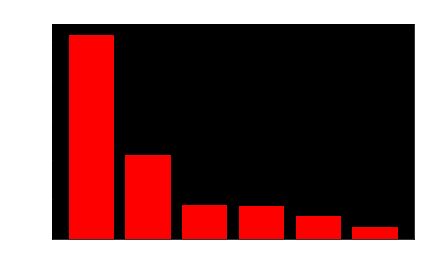

{1: 259, 2: 106, 3: 43, 4: 42, 5: 29, 6: 15}


{('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense',): 46,
 ('m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense',): 55,
 ('m5_nq_coqa_newsqa',): 62,
 ('m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean',): 41,
 ('m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense',): 16,
 ('m5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_3_2_dense',): 39,
 ('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense',
  'm4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense'): 56,
 ('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense',
  'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_2_2_dense'): 3,
 ('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense',
  'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_1_4_mean'): 8,
 ('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense',
  'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_3_2_dense'): 7,
 ('m4_nq_mag_off64_entq_ct_wt_ft_doc_2_2_dense', 'm5_nq_coqa_newsqa'): 2,
 ('m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense',
  'm5_nq_coqa_newsqa_mag_off_entq_ct_wt_ib_3_2_dense'): 2,
 ('m4_nq_mag_off_entq_ct_wt_ft_doc_2_2_dense',
  'm5_nq_coqa_newsqa_mag_off_e

In [21]:
from models.qa.base_generator import infer_to_str

_threshold = 0.01

def show_failures(name, pred_name = 'pred', threshold = _threshold, n = 5, indexes = [], verbose = True, show_ctx = True):
    path = os.path.join('mag_predictions', name, pred_name + '.json')
    
    data = load_json(path)
    if len(data) == 0: return []

    failed, failed_idx, impossible = [], [], []
    for i, (q, preds) in enumerate(data.items()):
        for ctx, p in preds.items():
            f1_i = [cand['F1'] for cand in p['candidates'] if 'F1' in cand]
            cum_f1 = [max(f1_i[:i+1]) for i in range(len(f1_i))]
            if len(f1_i) > 0 and cum_f1[-1] <= threshold:
                failed.append((q, ctx, p))
                failed_idx.append(i)
                if not any([t in ctx for t in p['target']]):
                    impossible.append(i)
    print("Model {} and pred {} ({} preds, {} failed) :".format(name, pred_name, len(data), len(failed)))
    if verbose: print("Failures ({}, {} impossibles) : {}".format(len(failed), len(impossible), np.array(failed_idx)))
    shown = 0
    for idx, (q, ctx, p) in zip(failed_idx, failed):
        if shown >= n: break
        if indexes and idx not in indexes: continue
            
        shown += 1
        txt = [c['text'] for c in p['candidates']]
        scores = [c['score'] for c in p['candidates']]
        if show_ctx:
            print("Context : {}\nQuestion : {}\nTarget : {}\n".format(
                ctx, q, p['target']
            ))
        print(infer_to_str(txt, scores))

    print('\n')
    if indexes: failed_idx = [idx for idx in failed_idx if idx in indexes]
    return failed_idx

def show_pred_for_indexes(indexes):
    names = sorted([
        n for n in os.listdir('mag_predictions') if n.startswith('m5_')
    ]) + [
        n for n in os.listdir('mag_predictions') if n.startswith('m4_')
    ]

    print(names)
    for idx in indexes:
        print("=" * 10 + "\nPredictions for index {}\n".format(idx) + "=" * 10)
        show_ctx = True
        for name in names:
            f = show_failures(name, 'pred', n = 1, indexes = [idx], verbose = False, show_ctx = show_ctx and 'doc' not in name)
            if len(f) > 0 and 'doc' not in name: show_ctx = False

all_failed = {}
done = {}
for model_name in os.listdir('mag_predictions'):
    for pred_name in ['pred', 'pred_doc']:
        if model_name in done: continue
        if not model_name.startswith('m'): continue
        for failed in show_failures(model_name, pred_name, n = 0, verbose = False):
            done[model_name] = True
            all_failed.setdefault(failed, []).append(model_name)

fail, failed_idx, nb_fail = {}, {}, {}
for idx, models_fail in sorted(all_failed.items(), key = lambda pair: len(pair[1])):
    fail.setdefault(tuple(models_fail), 0)
    fail[tuple(models_fail)] += 1
    nb_fail.setdefault(len(models_fail), 0)
    nb_fail[len(models_fail)] += 1
    failed_idx.setdefault(tuple(models_fail), []).append(idx)

indexes = list(failed_idx.items())[-1][1]
show_pred_for_indexes(indexes[:10])

nb = max(nb_fail.keys())
plot(
    x = list(range(1, nb + 1)),
    y = [nb_fail.get(i, 0) for i in range(1, max(nb_fail.keys()) + 1)],
    title = '# of models failing the same questions', xlabel = '# models failing', ylabel = '# questions',
    plot_type = 'bar', show = True,
    filename = 'memoire_results/plots/preds/failure_repartition.png'
)

print(nb_fail)
fail

## Datasets' analysis

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : model !
Successfully restored model from pretrained_models/m3_nq/saving/model.json !
Model m3_nq initialized successfully !
Loading dataset squad...
Dataset : squad (train)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count   86821.000000  86821.000000    86821.000000   86821.000000     86821.000000    86821.000000  86821.000000      86821.0
mean        4.655337      3.162772      156.916518     119.794347        12.357379       10.066378      4.638083          1.0
std         4.375183      3.390947       65.783588      49.409714         4.073695        3.555650      3.159001          0.0
min         1.000000      1.000000       26.000000      20.000000         1.000000        1.000000      1.000000          1.0
25%         2.000000      1.000000      115.000000    

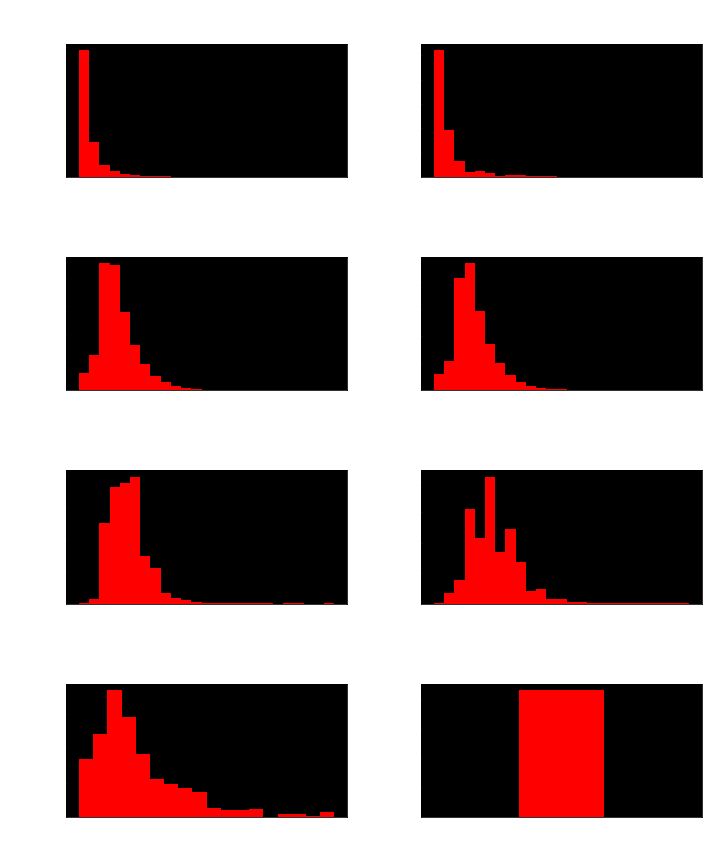

Dataset : squad (valid)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count    5928.000000   5928.000000     5928.000000    5928.000000      5928.000000     5928.000000   5928.000000       5928.0
mean        5.622301      3.987011      166.393725     128.505735        12.644737       10.363360      4.007928          1.0
std         4.851139      3.958704       74.373642      57.430026         4.198584        3.682464      1.889767          0.0
min         1.000000      1.000000       30.000000      25.000000         4.000000        3.000000      1.000000          1.0
25%         3.000000      2.000000      119.000000      93.000000        10.000000        8.000000      3.000000          1.0
50%         4.000000      3.000000      148.000000     114.000000        12.000000       10.000000      4.000000          1.0
75%         7.000000      5.000000      192.000000     149.000000        15.000000       12.00

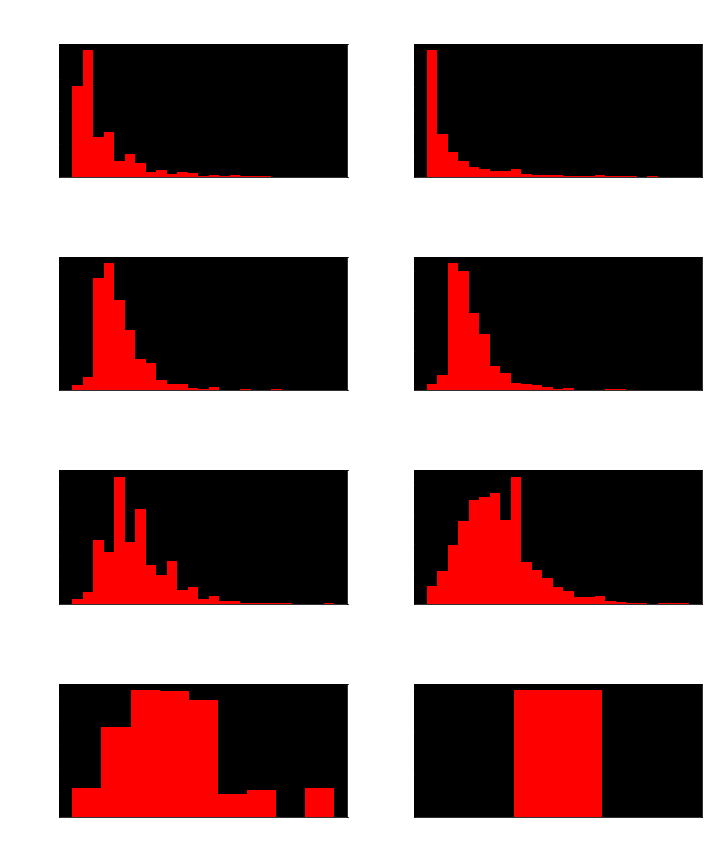

Loading dataset nq...
Dataset : nq (train)
       answer_tokens   answer_words  context_tokens  context_words  question_tokens  question_words   title_tokens    title_words
count  109866.000000  109866.000000   109866.000000  109866.000000    109866.000000   109866.000000  109866.000000  109866.000000
mean       16.450476      12.113666      313.233275     233.190450        10.391386        9.056196       6.892979       5.037118
std        29.486235      22.718714      223.419777     167.697635         2.153797        1.622143       3.784703       3.074092
min         0.000000       0.000000        1.000000       1.000000         7.000000        4.000000       1.000000       1.000000
25%         3.000000       2.000000      137.000000     101.000000         9.000000        8.000000       4.000000       3.000000
50%         4.000000       3.000000      254.000000     189.000000        10.000000        9.000000       6.000000       4.000000
75%        10.000000       7.000000      438.00

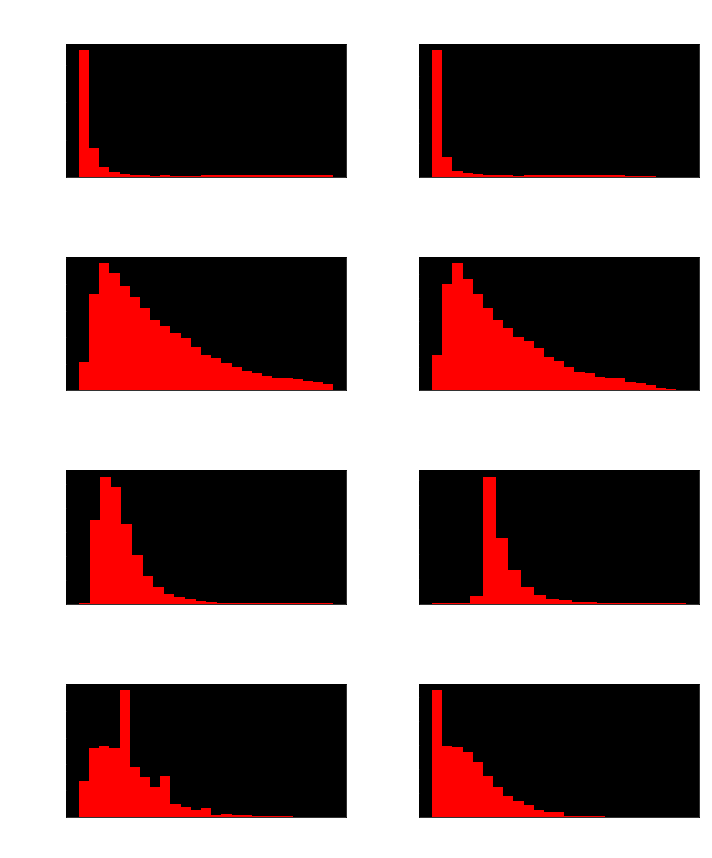

Dataset : nq (valid)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count    4195.000000   4195.000000     4195.000000    4195.000000      4195.000000     4195.000000   4195.000000  4195.000000
mean       16.329917     11.943266      315.983552     234.706794        10.469368        9.164482      7.087247     5.221454
std        26.981994     20.602608      221.625342     165.864769         2.276480        1.733599      3.973388     3.227847
min         1.000000      1.000000        2.000000       1.000000         7.000000        5.000000      1.000000     1.000000
25%         3.000000      2.000000      143.000000     106.000000         9.000000        8.000000      4.000000     3.000000
50%         5.000000      3.000000      258.000000     191.000000        10.000000        9.000000      6.000000     5.000000
75%        14.000000     10.000000      443.000000     330.500000        11.000000       10.00000

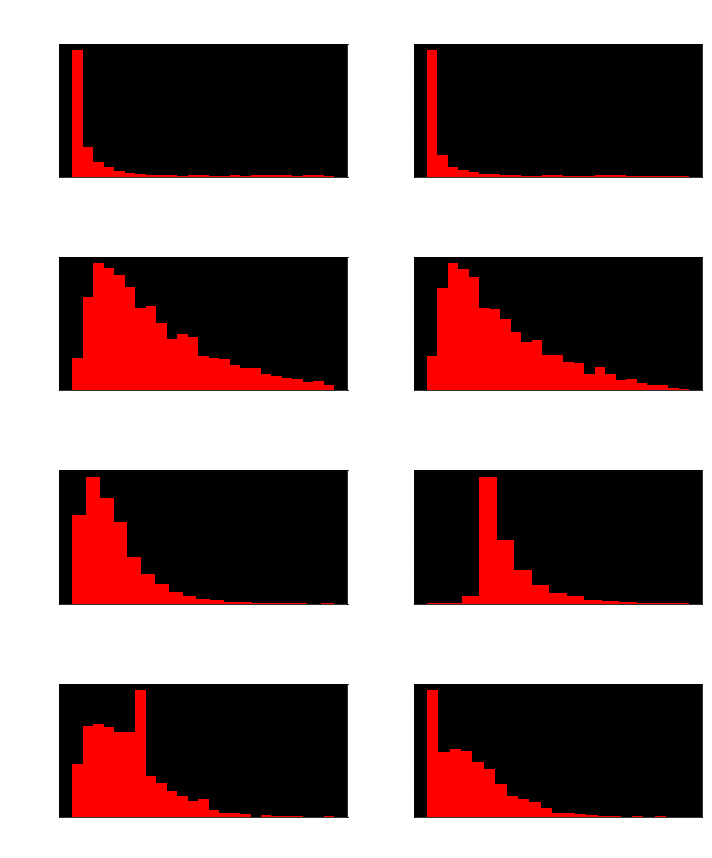

Loading dataset coqa...
Dataset : coqa (train)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count   74548.000000  74548.000000    74548.000000   74548.000000     74548.000000    74548.000000  74548.000000      74548.0
mean        3.574851      2.702997      354.674223     270.226954         6.721991        5.482682     13.146443          1.0
std         3.477037      2.757705       90.331656      67.160126         2.719001        2.498781     11.053926          0.0
min         1.000000      1.000000       89.000000      70.000000         1.000000        1.000000      3.000000          1.0
25%         1.000000      1.000000      307.000000     236.000000         5.000000        4.000000      5.000000          1.0
50%         3.000000      2.000000      355.000000     264.000000         6.000000        5.000000      6.000000          1.0
75%         5.000000      3.000000      390.000000     292.000000      

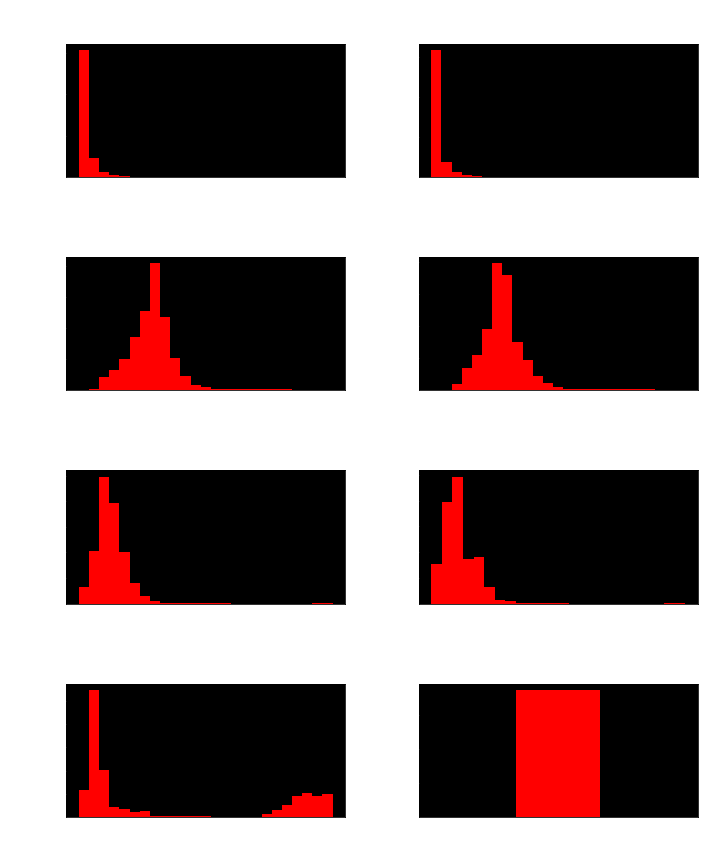

Dataset : coqa (valid)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count    5838.000000   5838.000000     5838.000000    5838.000000      5838.000000     5838.000000   5838.000000       5838.0
mean        3.361425      2.537684      339.175745     261.062350         6.664782        5.478417     11.970538          1.0
std         2.964451      2.315052      101.849200      74.840585         2.646269        2.463257     10.458456          0.0
min         1.000000      1.000000      148.000000     124.000000         1.000000        1.000000      3.000000          1.0
25%         1.000000      1.000000      267.000000     213.000000         5.000000        4.000000      5.000000          1.0
50%         2.000000      2.000000      346.000000     257.000000         6.000000        5.000000      6.000000          1.0
75%         4.000000      3.000000      391.000000     292.000000         8.000000        7.000

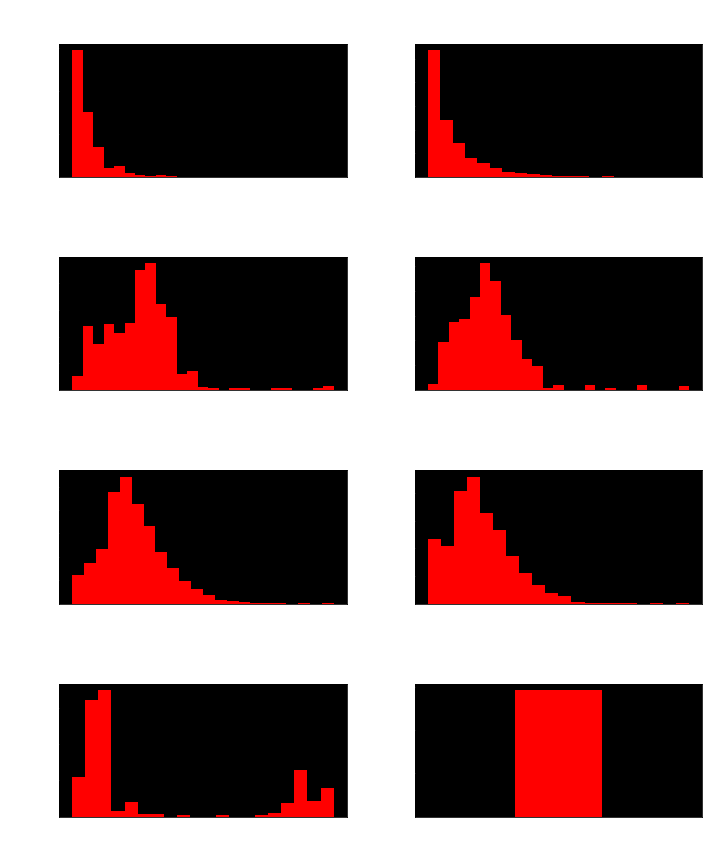

Loading dataset newsqa...
Dataset : newsqa (train)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens   title_words
count   56172.000000  56172.000000    56172.000000   56172.000000     56172.000000    56172.000000  56172.000000  56172.000000
mean        5.757958      3.942961      591.273731     453.421865         8.095421        6.588122      4.993965      1.974542
std         5.602048      4.527527      225.925872     176.310282         2.837980        2.371937      2.459778      1.119354
min         1.000000      1.000000       21.000000      14.000000         2.000000        2.000000      0.000000      0.000000
25%         2.000000      1.000000      408.000000     312.000000         6.000000        5.000000      3.000000      1.000000
50%         4.000000      2.000000      575.000000     440.000000         8.000000        6.000000      4.000000      2.000000
75%         7.000000      5.000000      781.000000     599.0

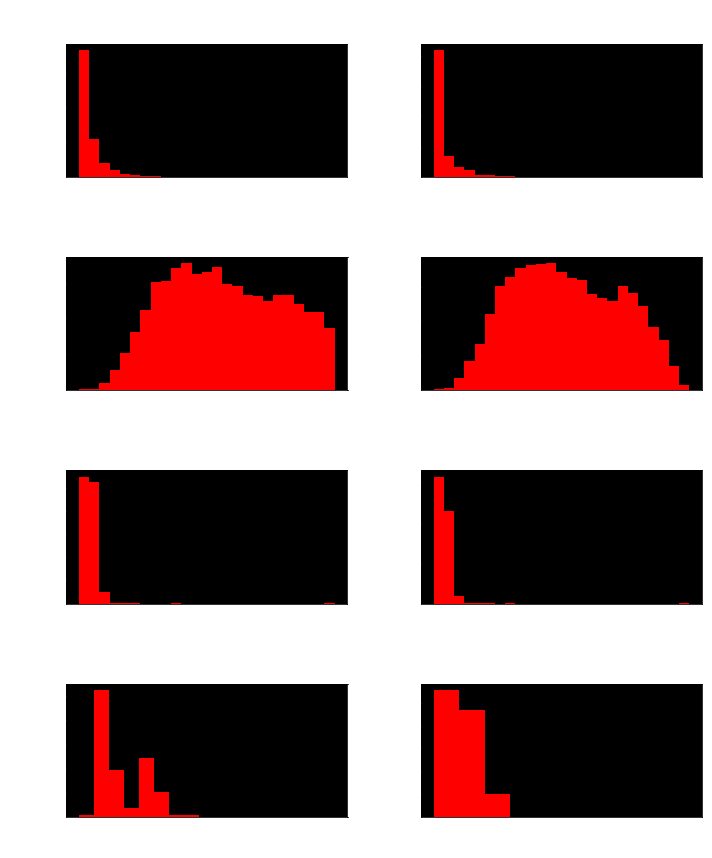

Dataset : newsqa (valid)
       answer_tokens  answer_words  context_tokens  context_words  question_tokens  question_words  title_tokens  title_words
count    3245.000000   3245.000000     3245.000000    3245.000000      3245.000000     3245.000000   3245.000000  3245.000000
mean        5.589831      3.818182      589.656703     450.824653         7.994761        6.493374      5.137750     2.016025
std         5.376201      4.382974      228.198203     176.909830         2.703660        2.242064      2.617016     1.152006
min         1.000000      1.000000      143.000000     106.000000         3.000000        2.000000      0.000000     0.000000
25%         2.000000      1.000000      401.000000     309.000000         6.000000        5.000000      3.000000     1.000000
50%         4.000000      2.000000      561.000000     436.000000         8.000000        6.000000      4.000000     1.000000
75%         7.000000      4.000000      778.000000     599.000000         9.000000        8.0

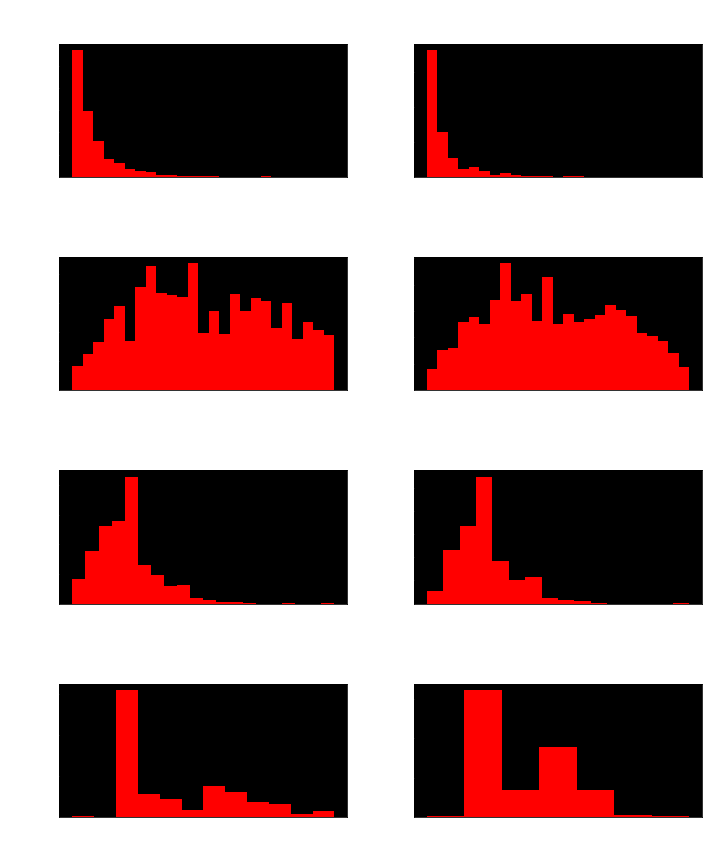

In [2]:
def analyse_ds(name, overwrite = False, ** kwargs):
    dataset = get_dataset(name, ** kwargs)

    for mode in ['train', 'valid']:
        filename = os.path.join('memoire_results', 'stats', '{}-{}.csv'.format(name, mode))
        os.makedirs(os.path.join('memoire_results', 'stats'), exist_ok = True)
        if os.path.exists(filename) and not overwrite:
            stats = pd.read_csv(filename, index_col = 0)
        else:
            stats = []
            for idx, row in tqdm(dataset[mode].iterrows(), total = len(dataset[mode])):
                stats.append({
                    'answer_tokens'      : [len(a) - 2 for a in model.encode_text(row['answers'])],
                    'answer_words'       : [len(a.strip().split()) for a in row['answers']],
                    'question_tokens'    : len(model.encode_text(row['question'])) - 2,
                    'question_words'     : len(row['question'].split()),
                    'context_tokens'    : len(model.encode_text(row['context'])) - 2,
                    'context_words'     : len(row['context'].split()),
                    'title_tokens'    : len(model.encode_text(row['title'])) - 2,
                    'title_words'     : len(row['title'].split())
                })
            stats = pd.DataFrame(stats)
            stats.to_csv(filename)
        #print(stats)

        stats['answer_tokens'] = stats['answer_tokens'].apply(
            lambda a: max([int(ai) for ai in a[1:-1].split(', ')] if isinstance(a, str) else a)
        )
        stats['answer_words'] = stats['answer_words'].apply(
            lambda a: max([int(ai) for ai in a[1:-1].split(', ')] if isinstance(a, str) else a)
        )
        stats = stats[stats['context_tokens'] <= 1024]
        stats = stats[stats['answer_tokens'] <= 128]
        stats = stats[stats['title_tokens'] <= 32]

        print("Dataset : {} ({})".format(name, mode))
        print(stats.describe())
        
        plot_multiple(** {
            '\n' + col.replace('_', ' ') : {'x' : stats[col].values, 'bins' : max(3, min(25, len(stats[col].unique())))}
            for col in stats.columns
                                           },
            title = 'Length distribution for {} ({})'.format(name, mode),
            xlabel = 'length', ylabel = '# pairs', ncols = 2, x_size = 5, y_size = 3,
            use_subplots = True, show = True,
            plot_type = 'hist', filename = filename.replace('.csv', '.png')
        )

model = get_pretrained(model_name)

_config = {
    'keep_mode'       : 'all',
    'skip_impossible' : True,
    'clean_text'      : True
}

for dataset in ['squad', 'nq', 'coqa', 'newsqa']:
    analyse_ds(dataset, overwrite = False, ** _config)